In [54]:
import pandas as pd
import sqlite3
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import warnings

warnings.filterwarnings('ignore')  

# 配置中文显示
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False

# 配置路径
data_path = r'D:\Postgraduate\工作\stage 1\archive\data.csv'
save_dir = r"D:\Postgraduate\工作\stage 1\archive\results"
os.makedirs(save_dir, exist_ok=True)  

print("🧹 开始数据清洗...")

# 1. 读取数据
df = pd.read_csv(data_path, encoding='latin-1')

# 2. 转换日期格式
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 3. 添加衍生字段
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Date'] = df['InvoiceDate'].dt.date

# 4. 计算总金额
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# 5. 识别退货订单
df['IsReturn'] = df['InvoiceNo'].str.startswith('C')

# 6. 数据清洗规则
df_clean = df[
    (df['Quantity'] > 0) &
    (df['UnitPrice'] > 0) &
    (df['CustomerID'].notna()) &
    (df['TotalAmount'] < 10000)
].copy()

print(f"✅ 原始数据: {len(df):,} 条")
print(f"✅ 清洗后数据: {len(df_clean):,} 条")
print(f"✅ 清洗掉: {len(df) - len(df_clean):,} 条 ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")

# ==================== 创建SQLite数据库 ====================
print("\n📦 创建SQLite数据库...")
conn = sqlite3.connect('ecommerce.db')
df_clean.to_sql('transactions', conn, index=False, if_exists='replace')

print(f"✅ 数据库创建成功！表名: transactions, 记录数: {len(df_clean):,} 条")

🧹 开始数据清洗...
✅ 原始数据: 541,909 条
✅ 清洗后数据: 397,881 条
✅ 清洗掉: 144,028 条 (26.6%)

📦 创建SQLite数据库...
✅ 数据库创建成功！表名: transactions, 记录数: 397,881 条


# 销售增长与时间分布

## 指标1：月度销售趋势分析

业务问题：整体销售额是增长还是下降？是否有明显的季节性？

In [36]:
# ==================== 指标1：月度销售趋势分析 ====================
print("\n" + "="*80)
print("📊 指标1：月度销售趋势分析".center(80))
print("="*80)

monthly_sales = pd.read_sql_query("""
    WITH monthly_gmv AS (
        SELECT
            Year,
            Month,
            ROUND(SUM(TotalAmount), 2) AS GMV
        FROM transactions
        GROUP BY Year, Month
    ),
    ranked_months AS (
        SELECT
            Year,
            Month,
            GMV,
            LAG(GMV) OVER (ORDER BY Year, Month) AS prev_gmv
        FROM monthly_gmv
    )
    SELECT
        Year AS 年,
        Month AS 月,
        GMV,
        CASE 
            WHEN prev_gmv IS NOT NULL AND prev_gmv <> 0 THEN
                ROUND((GMV - prev_gmv) * 100.0 / prev_gmv, 2)
            ELSE NULL
        END AS 环比增长率
    FROM ranked_months
    ORDER BY Year, Month;
""", conn)

print(monthly_sales)

# 统计分析
max_row = monthly_sales.loc[monthly_sales['GMV'].idxmax()]
min_row = monthly_sales.loc[monthly_sales['GMV'].idxmin()]

print("\n📈 月度销售趋势观察:")
print(f"- 销售额最高月: {int(max_row['年'])}年{int(max_row['月'])}月，GMV = £{max_row['GMV']:,.2f}")
print(f"- 销售额最低月: {int(min_row['年'])}年{int(min_row['月'])}月，GMV = £{min_row['GMV']:,.2f}")
print(f"- 平均GMV: £{monthly_sales['GMV'].mean():,.2f}")

# 保存数据
monthly_sales.to_csv(os.path.join(save_dir, '1_monthly_sales.csv'), index=False)


                                 📊 指标1：月度销售趋势分析                                 
       年   月         GMV  环比增长率
0   2010  12   572713.89    NaN
1   2011   1   492261.44 -14.05
2   2011   2   447137.35  -9.17
3   2011   3   595500.76  33.18
4   2011   4   469200.36 -21.21
5   2011   5   678594.56  44.63
6   2011   6   622243.69  -8.30
7   2011   7   600091.01  -3.56
8   2011   8   645343.90   7.54
9   2011   9   952838.38  47.65
10  2011  10  1039318.79   9.08
11  2011  11  1161817.38  11.79
12  2011  12   349723.19 -69.90

📈 月度销售趋势观察:
- 销售额最高月: 2011年11月，GMV = £1,161,817.38
- 销售额最低月: 2011年12月，GMV = £349,723.19
- 平均GMV: £663,598.82



📊 生成月度销售趋势图...


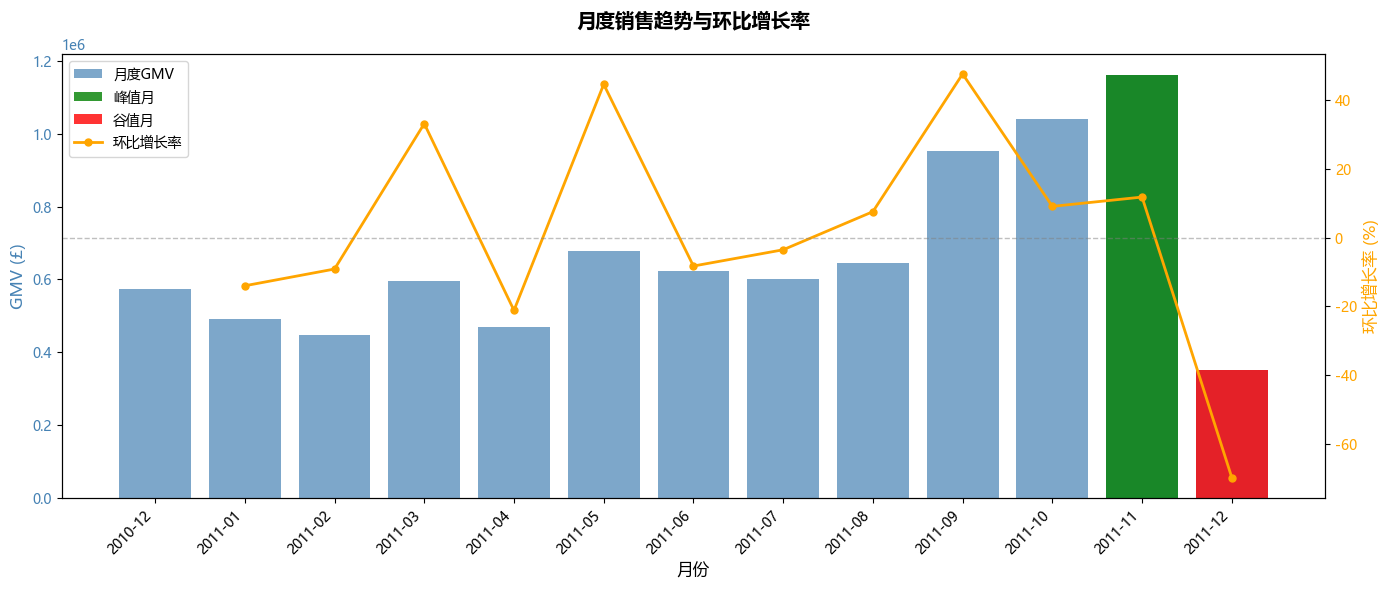

✅ 已保存: viz_1_monthly_trend.png


In [39]:
# -------------------- 可视化1：月度销售趋势 --------------------
print("\n📊 生成月度销售趋势图...")

monthly_sales['年月'] = monthly_sales['年'].astype(str) + '-' + monthly_sales['月'].astype(str).str.zfill(2)

fig, ax1 = plt.subplots(figsize=(14, 6))

# 主坐标轴：GMV柱状图
color = 'steelblue'
bars = ax1.bar(range(len(monthly_sales)), monthly_sales['GMV'], 
               color=color, alpha=0.7, label='月度GMV')
ax1.set_xlabel('月份', fontsize=12)
ax1.set_ylabel('GMV (£)', color=color, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(monthly_sales)))
ax1.set_xticklabels(monthly_sales['年月'], rotation=45, ha='right')

# 标注峰值和谷值
max_idx = monthly_sales['GMV'].idxmax()
min_idx = monthly_sales['GMV'].idxmin()
ax1.bar(max_idx, monthly_sales.loc[max_idx, 'GMV'], color='green', alpha=0.8, label='峰值月')
ax1.bar(min_idx, monthly_sales.loc[min_idx, 'GMV'], color='red', alpha=0.8, label='谷值月')

# 次坐标轴：环比增长率
ax2 = ax1.twinx()
valid_growth = monthly_sales['环比增长率'].dropna()
valid_indices = valid_growth.index
ax2.plot(valid_indices, valid_growth.values, 
         color='orange', marker='o', linewidth=2, markersize=5, label='环比增长率')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylabel('环比增长率 (%)', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')

# 图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.title('月度销售趋势与环比增长率', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_1_monthly_trend.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_1_monthly_trend.png")

## 指标2：Top商品分析（帕累托法则验证）

业务问题：哪些商品是核心收入来源？Top 20%商品是否贡献了80%收入？

In [4]:
# ==================== 指标2：商品结构分析 + 可视化 ====================
print("\n" + "="*80)
print("📊 指标2：商品结构分析（帕累托法则验证）".center(80))
print("="*80)

# 帕累托统计
pareto_stats = pd.read_sql_query("""
    WITH product_sales AS (
        SELECT
            StockCode,
            Description,
            SUM(Quantity) AS 总销量,
            ROUND(SUM(TotalAmount), 2) AS 总销售额,
            COUNT(DISTINCT InvoiceNo) AS 订单数,
            COUNT(DISTINCT CustomerID) AS 购买客户数
        FROM transactions
        WHERE Description IS NOT NULL
        GROUP BY StockCode, Description
    ),
    total_stats AS (
        SELECT 
            COUNT(*) AS 商品总数,
            SUM(总销售额) AS 总GMV
        FROM product_sales
    ),
    ranked_products AS (
        SELECT
            p.*,
            ROW_NUMBER() OVER (ORDER BY p.总销售额 DESC) AS 排名,
            ROUND(p.总销售额 * 100.0 / t.总GMV, 2) AS 销售额占比,
            ROUND(SUM(p.总销售额) OVER (ORDER BY p.总销售额 DESC) * 100.0 / t.总GMV, 2) AS 累计占比
        FROM product_sales p
        CROSS JOIN total_stats t
    )
    SELECT
        (SELECT 商品总数 FROM total_stats) AS 商品总数,
        (SELECT 总GMV FROM total_stats) AS 总GMV,
        COUNT(*) FILTER (WHERE 排名 <= (SELECT 商品总数 * 0.2 FROM total_stats)) AS Top20商品数,
        ROUND(SUM(总销售额) FILTER (WHERE 排名 <= (SELECT 商品总数 * 0.2 FROM total_stats)), 2) AS Top20销售额,
        ROUND(SUM(总销售额) FILTER (WHERE 排名 <= (SELECT 商品总数 * 0.2 FROM total_stats)) * 100.0 / (SELECT 总GMV FROM total_stats), 2) AS Top20贡献率,
        MIN(排名) FILTER (WHERE 累计占比 >= 80) AS 贡献80收入的商品数
    FROM ranked_products;
""", conn)

print("\n📊 帕累托分析（80/20法则验证）:")
print(pareto_stats.T)

total_products = pareto_stats['商品总数'][0]
top20_count = pareto_stats['Top20商品数'][0]
top20_ratio = pareto_stats['Top20贡献率'][0]
products_for_80 = pareto_stats['贡献80收入的商品数'][0]

print("\n💡 核心发现：")
print(f"- Top 20% 商品 ({top20_count}/{total_products}) 贡献 {top20_ratio}% 的收入")
print(f"- 贡献 80% 收入仅需 {products_for_80} 个商品 ({products_for_80/total_products*100:.1f}%)")

# Top 10商品
top10_products = pd.read_sql_query("""
    WITH product_sales AS (
        SELECT
            StockCode,
            Description,
            SUM(Quantity) AS 总销量,
            ROUND(SUM(TotalAmount), 2) AS 总销售额,
            COUNT(DISTINCT InvoiceNo) AS 订单数,
            COUNT(DISTINCT CustomerID) AS 购买客户数,
            ROUND(AVG(TotalAmount), 2) AS 平均订单金额
        FROM transactions
        WHERE Description IS NOT NULL
        GROUP BY StockCode, Description
    )
    SELECT
        *,
        ROUND(总销售额 * 100.0 / SUM(总销售额) OVER (), 2) AS 销售额占比
    FROM product_sales
    ORDER BY 总销售额 DESC
    LIMIT 10;
""", conn)

print("\n🏆 Top 10 畅销商品:")
print(top10_products.to_string(index=False))

# 分位数分布
tail_products = pd.read_sql_query("""
    WITH product_sales AS (
        SELECT
            StockCode,
            Description,
            SUM(Quantity) AS 总销量,
            ROUND(SUM(TotalAmount), 2) AS 总销售额
        FROM transactions
        WHERE Description IS NOT NULL
        GROUP BY StockCode, Description
    ),
    ranked AS (
        SELECT
            *,
            NTILE(10) OVER (ORDER BY 总销售额 DESC) AS 分位数
        FROM product_sales
    )
    SELECT
        分位数,
        COUNT(*) AS 商品数,
        ROUND(SUM(总销售额), 2) AS 总销售额,
        ROUND(SUM(总销售额) * 100.0 / SUM(SUM(总销售额)) OVER (), 2) AS 占比
    FROM ranked
    GROUP BY 分位数
    ORDER BY 分位数;
""", conn)

print("\n📊 商品销售分位数分布:")
print(tail_products.to_string(index=False))


                             📊 指标2：商品结构分析（帕累托法则验证）                              

📊 帕累托分析（80/20法则验证）:
                     0
商品总数           3896.00
总GMV        8626784.70
Top20商品数        779.00
Top20销售额    6766956.59
Top20贡献率         78.44
贡献80收入的商品数      832.00

💡 核心发现：
- Top 20% 商品 (779/3896) 贡献 78.44% 的收入
- 贡献 80% 收入仅需 832 个商品 (21.4%)

🏆 Top 10 畅销商品:
StockCode                        Description   总销量      总销售额  订单数  购买客户数  平均订单金额  销售额占比
    22423           REGENCY CAKESTAND 3 TIER 12402 142592.95 1703    881   82.76   1.65
   85123A WHITE HANGING HEART T-LIGHT HOLDER 36725 100448.15 1971    856   49.53   1.16
   85099B            JUMBO BAG RED RETROSPOT 46181  85220.78 1600    635   52.67   0.99
     POST                            POSTAGE  3120  77803.96 1099    331   70.80   0.90
    47566                      PARTY BUNTING 15291  68844.33 1379    708   49.32   0.80
    84879      ASSORTED COLOUR BIRD ORNAMENT 35362  56580.34 1375    678   40.18   0.66
        M                  

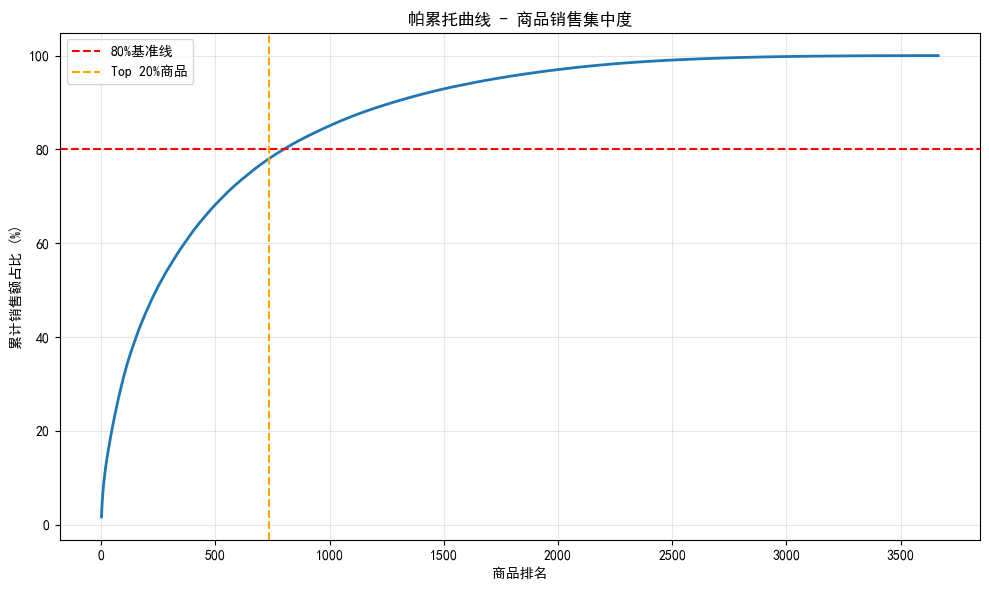

In [33]:
# -------------------- 可视化2a：帕累托曲线--------------------
cumulative_data = pd.read_sql_query("""
    WITH product_sales AS (
        SELECT
            StockCode,
            ROUND(SUM(TotalAmount), 2) AS 总销售额
        FROM transactions
        WHERE Description IS NOT NULL
        GROUP BY StockCode
    )
    SELECT
        ROW_NUMBER() OVER (ORDER BY 总销售额 DESC) AS 排名,
        ROUND(SUM(总销售额) OVER (ORDER BY 总销售额 DESC) * 100.0 / SUM(总销售额) OVER (), 2) AS 累计占比
    FROM product_sales
    ORDER BY 排名;
""", conn)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_data['排名'], cumulative_data['累计占比'], linewidth=2)
plt.axhline(y=80, color='r', linestyle='--', label='80%基准线')
plt.axvline(x=len(cumulative_data)*0.2, color='orange', linestyle='--', label='Top 20%商品')
plt.xlabel('商品排名')
plt.ylabel('累计销售额占比 (%)')
plt.title('帕累托曲线 - 商品销售集中度')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, '2_pareto_curve.png'), dpi=300)
plt.show()


📊 生成商品销售分位数分布图...


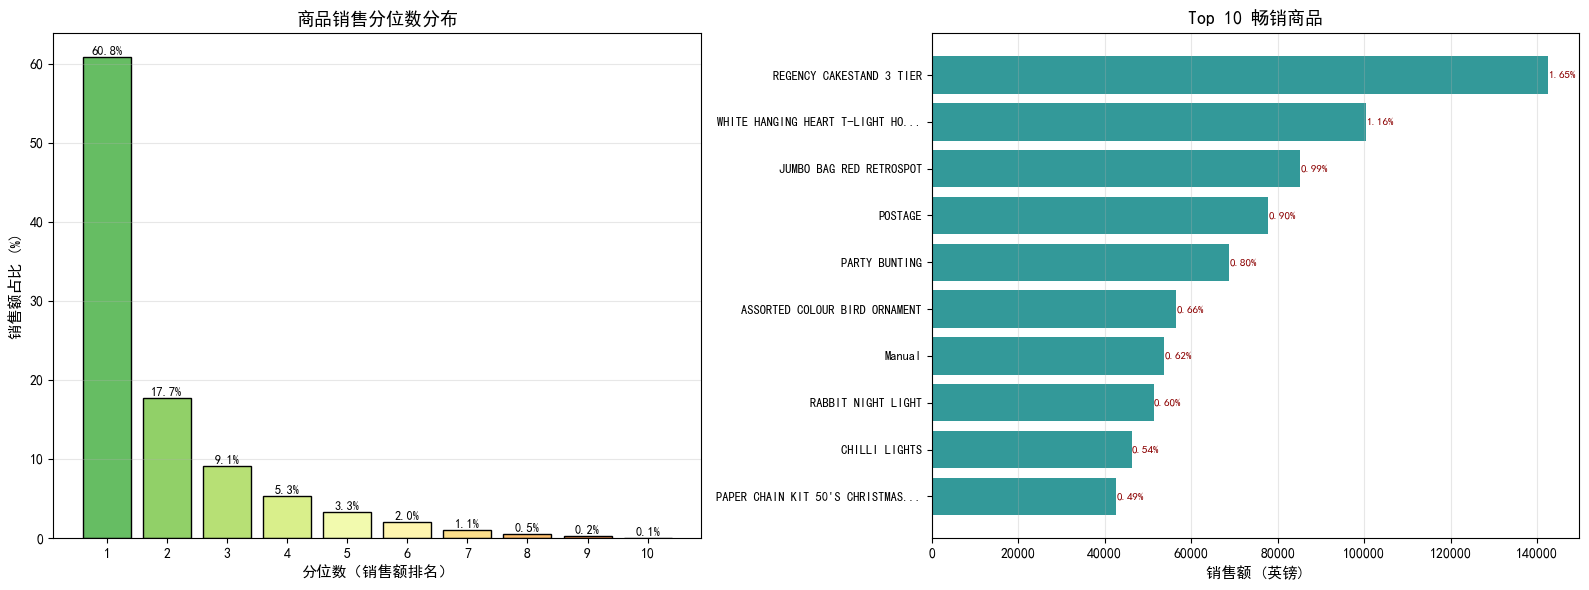

✅ 已保存: viz_2_product_structure.png


In [34]:
# -------------------- 可视化2b：商品结构综合分析--------------------
print("\n📊 生成商品销售分位数分布图...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左图：分位数销售额占比
ax1 = axes[0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(tail_products)))
bars = ax1.bar(tail_products['分位数'].astype(str), tail_products['占比'], color=colors, edgecolor='black')
ax1.set_xlabel('分位数（销售额排名）', fontsize=11)
ax1.set_ylabel('销售额占比 (%)', fontsize=11)
ax1.set_title('商品销售分位数分布', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 右图：Top 10商品销售额占比
ax2 = axes[1]
top10_sorted = top10_products.sort_values('总销售额', ascending=True)
y_pos = np.arange(len(top10_sorted))
bars2 = ax2.barh(y_pos, top10_sorted['总销售额'], color='teal', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([desc[:30] + '...' if len(desc) > 30 else desc 
                      for desc in top10_sorted['Description']], fontsize=9)
ax2.set_xlabel('销售额 (£)', fontsize=11)
ax2.set_title('Top 10 畅销商品', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (bar, pct) in enumerate(zip(bars2, top10_sorted['销售额占比'])):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2., 
             f'{pct:.2f}%', ha='left', va='center', fontsize=8, color='darkred', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_2_product_structure.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_2_product_structure.png")


## 指标3：国家市场表现

业务问题：哪些国家是核心市场？是否有潜力市场？

In [35]:
# ==================== 指标3：国家市场分析 + 可视化 ====================
print("\n" + "="*80)
print("🌍 指标3：国家市场分析".center(80))
print("="*80)

country_analysis = pd.read_sql_query("""
    WITH country_stats AS (
        SELECT
            Country,
            COUNT(DISTINCT CustomerID) AS 客户数,
            COUNT(DISTINCT InvoiceNo) AS 订单数,
            ROUND(SUM(TotalAmount), 2) AS 总销售额,
            ROUND(AVG(TotalAmount), 2) AS 平均订单行金额,
            ROUND(SUM(TotalAmount) / COUNT(DISTINCT InvoiceNo), 2) AS 平均客单价,
            ROUND(SUM(TotalAmount) / COUNT(DISTINCT CustomerID), 2) AS 人均消费
        FROM transactions
        GROUP BY Country
    ),
    total_gmv AS (
        SELECT SUM(总销售额) AS 全球总GMV
        FROM country_stats
    )
    SELECT
        c.*,
        ROUND(c.总销售额 * 100.0 / t.全球总GMV, 2) AS 销售额占比,
        ROUND(SUM(c.总销售额) OVER (ORDER BY c.总销售额 DESC) * 100.0 / t.全球总GMV, 2) AS 累计占比
    FROM country_stats c
    CROSS JOIN total_gmv t
    ORDER BY c.总销售额 DESC;
""", conn)

print("\n🌍 国家市场分析（Top 15）:")
print(country_analysis.head(15).to_string(index=False))

# 核心指标提取
core_markets = country_analysis[country_analysis['累计占比'] <= 90]
uk_data = country_analysis[country_analysis['Country'] == 'United Kingdom'].iloc[0]
overseas = country_analysis[country_analysis['Country'] != 'United Kingdom']
overseas_gmv = overseas['总销售额'].sum()
overseas_pct = (overseas_gmv / country_analysis['总销售额'].sum()) * 100

print(f"\n💡 核心市场数量: {len(core_markets)} / {len(country_analysis)}")
print(f"\n🇬🇧 英国市场: GMV £{uk_data['总销售额']:,.2f} ({uk_data['销售额占比']:.2f}%)")
print(f"🌏 海外市场: {len(overseas)}国，GMV £{overseas_gmv:,.2f} ({overseas_pct:.2f}%)")

top5_overseas = overseas.head(5)
print(f"\n🏆 Top 5 海外市场:")
print(top5_overseas[['Country', '总销售额', '客户数', '人均消费']].to_string(index=False))

high_value_markets = country_analysis[country_analysis['人均消费'] > 5000]
print(f"\n💎 高价值市场（人均消费>£5000）:")
print(high_value_markets[['Country', '客户数', '人均消费', '平均客单价']].to_string(index=False))


                                  🌍 指标3：国家市场分析                                  

🌍 国家市场分析（Top 15）:
       Country  客户数   订单数       总销售额  平均订单行金额   平均客单价     人均消费  销售额占比  累计占比
United Kingdom 3919 16643 7023768.35    19.82  422.03  1792.23  81.42 81.42
   Netherlands    9    94  285446.34   121.00 3036.66 31716.26   3.31 84.73
          EIRE    3   260  265545.90    36.70 1021.33 88515.30   3.08 87.81
       Germany   94   457  228867.14    25.32  500.80  2434.76   2.65 90.46
        France   87   389  209024.05    25.06  537.34  2402.58   2.42 92.88
     Australia    9    57  138521.31   117.19 2430.20 15391.26   1.61 94.49
         Spain   30    90   61577.11    24.79  684.19  2052.57   0.71 95.20
   Switzerland   21    51   56443.95    30.66 1106.74  2687.81   0.65 95.85
       Belgium   25    98   41196.34    20.28  420.37  1647.85   0.48 96.33
        Sweden    8    36   38378.33    85.10 1066.06  4797.29   0.44 96.78
         Japan    8    19   37416.37   116.56 1969.28  4677.05 


📊 生成国家市场分析图...


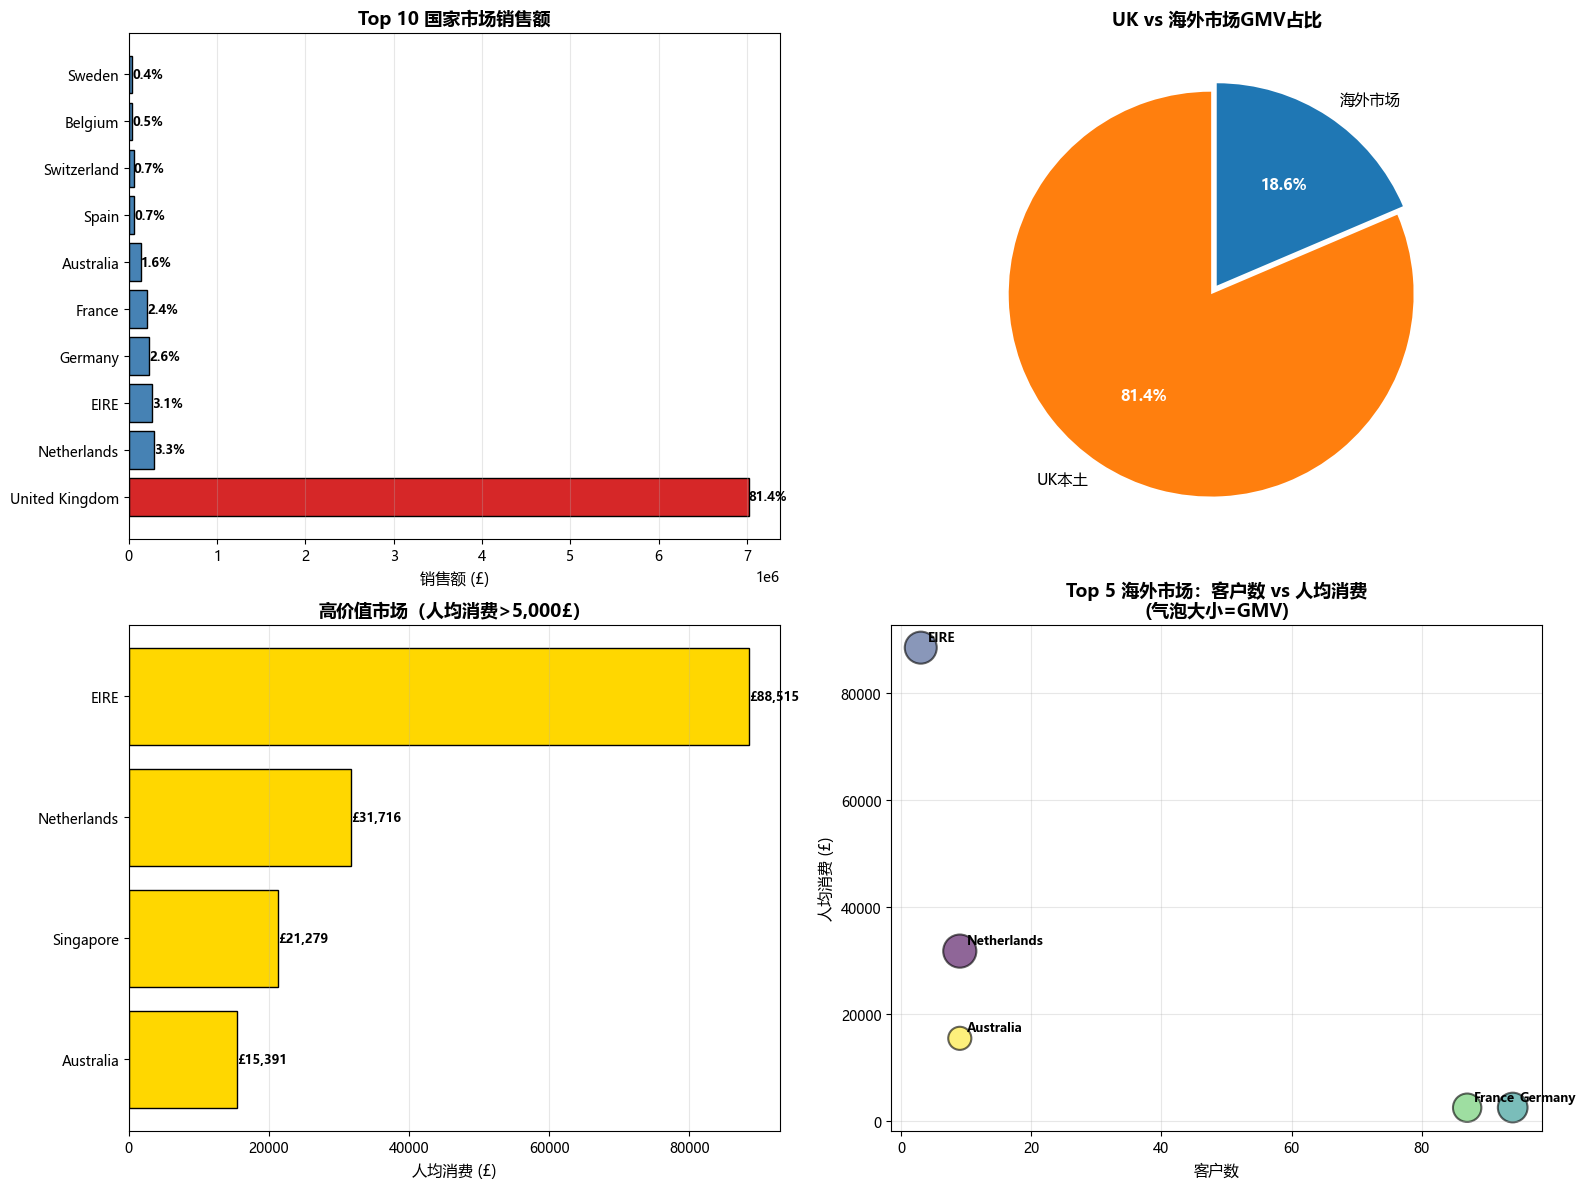

✅ 已保存: viz_3_country_analysis.png


In [40]:
# -------------------- 可视化3：国家市场分析 --------------------
print("\n📊 生成国家市场分析图...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 左上：Top 10国家GMV对比
ax1 = axes[0, 0]
top10_countries = country_analysis.head(10)
colors_map = ['#d62728' if c == 'United Kingdom' else 'steelblue' for c in top10_countries['Country']]
bars = ax1.barh(range(len(top10_countries)), top10_countries['总销售额'], color=colors_map, edgecolor='black')
ax1.set_yticks(range(len(top10_countries)))
ax1.set_yticklabels(top10_countries['Country'], fontsize=10)
ax1.set_xlabel('销售额 (£)', fontsize=11)
ax1.set_title('Top 10 国家市场销售额', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, (bar, pct) in enumerate(zip(bars, top10_countries['销售额占比'])):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2., 
             f'{pct:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

# 右上：UK vs 海外市场饼图
ax2 = axes[0, 1]
uk_gmv = uk_data['总销售额']
labels = ['UK本土', '海外市场']
sizes = [uk_gmv, overseas_gmv]
colors_pie = ['#ff7f0e', '#1f77b4']
explode = (0.05, 0)
wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, colors=colors_pie,
                                     autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('UK vs 海外市场GMV占比', fontsize=13, fontweight='bold')

# 左下：高价值市场人均消费
ax3 = axes[1, 0]
if len(high_value_markets) > 0:
    hv_sorted = high_value_markets.sort_values('人均消费', ascending=True)
    y_pos = np.arange(len(hv_sorted))
    bars3 = ax3.barh(y_pos, hv_sorted['人均消费'], color='gold', edgecolor='black')
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels(hv_sorted['Country'], fontsize=10)
    ax3.set_xlabel('人均消费 (£)', fontsize=11)
    ax3.set_title('高价值市场（人均消费>5,000£）', fontsize=13, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    
    for i, bar in enumerate(bars3):
        width = bar.get_width()
        ax3.text(width, bar.get_y() + bar.get_height()/2., 
                 f'£{width:,.0f}', ha='left', va='center', fontsize=9, fontweight='bold')
else:
    ax3.text(0.5, 0.5, '无高价值市场数据', ha='center', va='center', fontsize=12)
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis('off')

# 右下：Top 5海外市场散点图
ax4 = axes[1, 1]
top5_overseas_data = overseas.head(5)
scatter = ax4.scatter(top5_overseas_data['客户数'], top5_overseas_data['人均消费'], 
                      s=top5_overseas_data['总销售额']/500, alpha=0.6, c=range(len(top5_overseas_data)), 
                      cmap='viridis', edgecolors='black', linewidth=1.5)
ax4.set_xlabel('客户数', fontsize=11)
ax4.set_ylabel('人均消费 (£)', fontsize=11)
ax4.set_title('Top 5 海外市场：客户数 vs 人均消费\n(气泡大小=GMV)', fontsize=13, fontweight='bold')
ax4.grid(alpha=0.3)

for idx, row in top5_overseas_data.iterrows():
    ax4.annotate(row['Country'], (row['客户数'], row['人均消费']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_3_country_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_3_country_analysis.png")

## 指标4：时间维度分析

业务问题

    一天中哪个时间段订单最多？
    
    周几的销售额最高？
    
    是否存在"下班时间购物高峰"？

In [9]:
# ==================== 指标4：时间维度分析====================

# 按小时分析
hourly_pattern = pd.read_sql_query("""
   SELECT
       Hour as 小时,
       COUNT(DISTINCT InvoiceNo) as 订单数,
       ROUND(SUM(TotalAmount), 2) as GMV,
       ROUND(AVG(TotalAmount), 2) as 平均订单行金额,
       COUNT(DISTINCT CustomerID) as 活跃客户数
   FROM transactions
   GROUP BY Hour
   ORDER BY Hour
""", conn)

print("\n📊 每小时订单分布:")
print(hourly_pattern.to_string(index=False))

# 找出高峰时段
peak_hour_idx = hourly_pattern['订单数'].idxmax()
peak_hour = hourly_pattern.loc[peak_hour_idx]
low_hour_idx = hourly_pattern['订单数'].idxmin()
low_hour = hourly_pattern.loc[low_hour_idx]

print(f"\n💡 关键发现:")
print(f"   - 订单高峰: {int(peak_hour['小时'])}点（{peak_hour['订单数']}单，GMV £{peak_hour['GMV']:,.2f}）")
print(f"   - 订单低谷: {int(low_hour['小时'])}点（{low_hour['订单数']}单）")

# 按星期分析
weekly_pattern = pd.read_sql_query("""
   SELECT
       CASE DayOfWeek
           WHEN 0 THEN '周一'
           WHEN 1 THEN '周二'
           WHEN 2 THEN '周三'
           WHEN 3 THEN '周四'
           WHEN 4 THEN '周五'
           WHEN 5 THEN '周六'
           WHEN 6 THEN '周日'
       END as 星期,
       DayOfWeek,
       COUNT(DISTINCT InvoiceNo) as 订单数,
       ROUND(SUM(TotalAmount), 2) as GMV,
       COUNT(DISTINCT CustomerID) as 活跃客户数
   FROM transactions
   GROUP BY DayOfWeek
   ORDER BY DayOfWeek
""", conn)

print("\n📅 每周订单分布:")
print(weekly_pattern[['星期', '订单数', 'GMV', '活跃客户数']].to_string(index=False))

# 工作日 vs 周末
weekday_gmv = weekly_pattern[weekly_pattern['DayOfWeek'] < 5]['GMV'].sum()
weekend_gmv = weekly_pattern[weekly_pattern['DayOfWeek'] >= 5]['GMV'].sum()
weekend_ratio = weekend_gmv / (weekday_gmv + weekend_gmv) * 100

print(f"\n💡 工作日 vs 周末:")
print(f"   - 工作日GMV: £{weekday_gmv:,.2f}")
print(f"   - 周末GMV: £{weekend_gmv:,.2f}")
print(f"   - 周末占比: {weekend_ratio:.2f}%")

# 营业时间分析
business_hours = hourly_pattern[(hourly_pattern['小时'] >= 6) & (hourly_pattern['小时'] <= 20)]
business_gmv = business_hours['GMV'].sum()
total_gmv = hourly_pattern['GMV'].sum()
business_ratio = business_gmv / total_gmv * 100

print(f"\n💡 营业时间分析（6-20点）:")
print(f"   - 营业时间GMV: £{business_gmv:,.2f}")
print(f"   - 占总GMV: {business_ratio:.2f}%")


📊 每小时订单分布:
 小时  订单数        GMV  平均订单行金额  活跃客户数
  6    1       4.25     4.25      1
  7   29   31059.21    81.95     28
  8  555  282115.63    32.46    427
  9 1392  674135.57    30.72    890
 10 2225 1184008.97    31.16   1267
 11 2277 1104558.75    22.50   1303
 12 3130 1378571.48    19.13   1637
 13 2636 1173264.75    18.32   1573
 14 2274  995629.37    18.40   1386
 15 2036  927221.75    20.44   1275
 16 1100  468885.80    19.46    749
 17  544  234413.52    17.93    414
 18  169  104954.43    35.85    141
 19  144   49028.46    14.76     98
 20   18   18932.76    23.61     15

💡 关键发现:
   - 订单高峰: 12点（3130.0单，GMV £1,378,571.48）
   - 订单低谷: 6点（1.0单）

📅 每周订单分布:
星期  订单数        GMV  活跃客户数
周一 2863 1367146.41   1595
周二 3183 1623451.03   1700
周三 3455 1588336.17   1778
周四 4032 1976859.07   2007
周五 2827 1278477.80   1556
周日 2169  792514.22   1225

💡 工作日 vs 周末:
   - 工作日GMV: £7,834,270.48
   - 周末GMV: £792,514.22
   - 周末占比: 9.19%

💡 营业时间分析（6-20点）:
   - 营业时间GMV: £8,626,784.70
   - 占总GMV: 100.00%



📊 生成时间维度分析图...


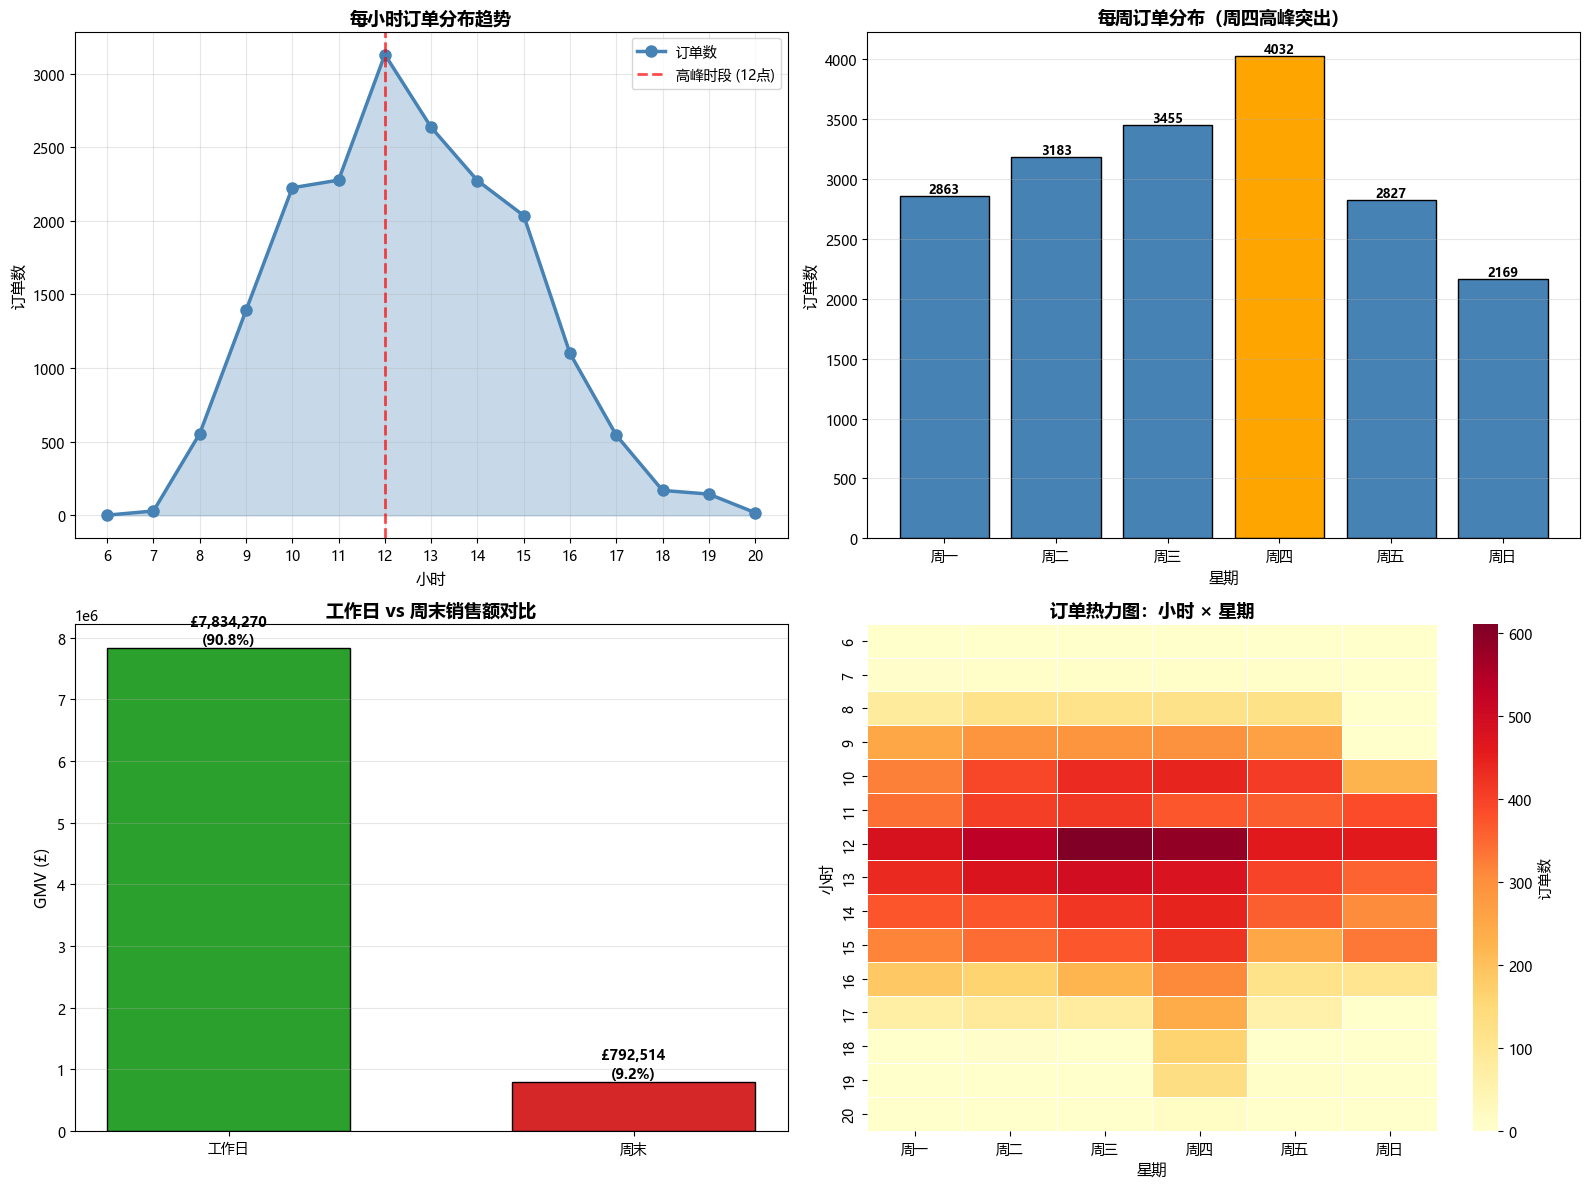

✅ 已保存: viz_4_time_analysis.png

                                ✅ 销售增长与结构分析已完成！                                 

📁 保存位置: D:\Postgraduate\工作\stage 1\archive\results

📊 生成文件:
   ├── 1_monthly_sales.csv           (月度销售数据)
   ├── viz_1_monthly_trend.png       (月度销售趋势)
   ├── 2_pareto_curve.png            (帕累托曲线)
   ├── viz_2_product_structure.png   (商品结构分析)
   ├── viz_3_country_analysis.png    (国家市场分析)
   └── viz_4_time_analysis.png       (时间维度分析)

💡 核心发现:
   1. 月度销售存在明显季节性，11月峰值后12月暴跌
   2. 商品结构符合帕累托法则，但缺乏超级爆款
   3. UK市场占比81.42%，海外高价值市场待挖掘
   4. B2B特征明显，工作日占比90.81%，周四异常突出


In [44]:
# -------------------- 可视化4：时间维度分析 --------------------
print("\n📊 生成时间维度分析图...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 左上：每小时订单趋势
ax1 = axes[0, 0]
ax1.plot(hourly_pattern['小时'], hourly_pattern['订单数'], 
        marker='o', linewidth=2.5, markersize=8, color='steelblue', label='订单数')
ax1.fill_between(hourly_pattern['小时'], hourly_pattern['订单数'], alpha=0.3, color='steelblue')
ax1.axvline(x=peak_hour['小时'], color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'高峰时段 ({int(peak_hour["小时"])}点)')
ax1.set_xlabel('小时', fontsize=11)
ax1.set_ylabel('订单数', fontsize=11)
ax1.set_title('每小时订单分布趋势', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(6, 21))

# 右上：每周订单分布
ax2 = axes[0, 1]
colors_week = ['orange' if day == 3 else 'steelblue' for day in weekly_pattern['DayOfWeek']]  # 周四高亮
bars = ax2.bar(weekly_pattern['星期'], weekly_pattern['订单数'], color=colors_week, edgecolor='black')
ax2.set_xlabel('星期', fontsize=11)
ax2.set_ylabel('订单数', fontsize=11)
ax2.set_title('每周订单分布（周四高峰突出）', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
   height = bar.get_height()
   ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 左下：工作日 vs 周末GMV对比
ax3 = axes[1, 0]
weekday_weekend = pd.DataFrame({
   '类型': ['工作日', '周末'],
   'GMV': [weekday_gmv, weekend_gmv],
   '占比': [100 - weekend_ratio, weekend_ratio]
})
bars3 = ax3.bar(weekday_weekend['类型'], weekday_weekend['GMV'], 
               color=['#2ca02c', '#d62728'], edgecolor='black', width=0.6)
ax3.set_ylabel('GMV (£)', fontsize=11)
ax3.set_title('工作日 vs 周末销售额对比', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars3):
   height = bar.get_height()
   ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'£{height:,.0f}\n({weekday_weekend.iloc[i]["占比"]:.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 右下：小时 × 星期热力图（自适应缺失星期）
heatmap_data = pd.read_sql_query("""
    SELECT
        Hour as 小时,
        DayOfWeek as 星期,
        COUNT(DISTINCT InvoiceNo) as 订单数
    FROM transactions
    WHERE Hour BETWEEN 6 AND 20
    GROUP BY Hour, DayOfWeek
""", conn)

# 透视表（保留原始星期编号0-6）
pivot = heatmap_data.pivot(index='小时', columns='星期', values='订单数').fillna(0)

# 动态生成星期标签（只标注实际存在的星期）
weekday_labels = {0: '周一', 1: '周二', 2: '周三', 3: '周四', 4: '周五', 5: '周六', 6: '周日'}
pivot.columns = [weekday_labels.get(col, f'星期{col}') for col in pivot.columns]

ax4 = axes[1, 1]
sns.heatmap(pivot, annot=False, fmt='g', cmap='YlOrRd', cbar_kws={'label': '订单数'}, 
            linewidths=0.5, ax=ax4)
ax4.set_xlabel('星期', fontsize=11)
ax4.set_ylabel('小时', fontsize=11)
ax4.set_title('订单热力图：小时 × 星期', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_4_time_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_4_time_analysis.png")


# ==================== 总结报告 ====================
print("\n" + "="*80)
print("✅ 销售增长与结构分析已完成！".center(80))
print("="*80)
print(f"\n📁 保存位置: {save_dir}")
print("\n📊 生成文件:")
print("   ├── 1_monthly_sales.csv           (月度销售数据)")
print("   ├── viz_1_monthly_trend.png       (月度销售趋势)")
print("   ├── 2_pareto_curve.png            (帕累托曲线)")
print("   ├── viz_2_product_structure.png   (商品结构分析)")
print("   ├── viz_3_country_analysis.png    (国家市场分析)")
print("   └── viz_4_time_analysis.png       (时间维度分析)")
print("\n💡 核心发现:")
print("   1. 月度销售存在明显季节性，11月峰值后12月暴跌")
print("   2. 商品结构符合帕累托法则，但缺乏超级爆款")
print("   3. UK市场占比81.42%，海外高价值市场待挖掘")
print("   4. B2B特征明显，工作日占比90.81%，周四异常突出")
print("="*80)


# 客户价值分析

## 指标5：客单价分布分析

业务问题：客户的消费能力如何分布？

In [17]:
# ==================== 指标5：客单价分布分析 ====================
print("\n" + "="*80)
print("💰 指标5：客单价分布分析".center(80))
print("="*80)

# Step 1: SQL查询
customer_spending = pd.read_sql_query("""
    SELECT
        CustomerID,
        COUNT(DISTINCT InvoiceNo) as 订单数,
        SUM(Quantity) as 购买商品数,
        ROUND(SUM(TotalAmount), 2) as 总消费金额,
        ROUND(AVG(TotalAmount), 2) as 平均订单行金额,
        ROUND(SUM(TotalAmount) / COUNT(DISTINCT InvoiceNo), 2) as 平均客单价,
        MIN(InvoiceDate) as 首次购买日期,
        MAX(InvoiceDate) as 最近购买日期
    FROM transactions
    GROUP BY CustomerID
""", conn)

# Step 2: 统计描述
print("\n📊 客户消费金额统计:")
desc_stats = customer_spending['总消费金额'].describe()
print(f"- 客户总数: {len(customer_spending):,}")
print(f"- 平均消费: £{desc_stats['mean']:,.2f}")
print(f"- 中位数: £{desc_stats['50%']:,.2f}")
print(f"- 标准差: £{desc_stats['std']:,.2f}")
print(f"- 最小值: £{desc_stats['min']:,.2f}")
print(f"- 最大值: £{desc_stats['max']:,.2f}")

# Step 3: 分位数分析
print("\n📈 分位数分析:")
percentiles = customer_spending['总消费金额'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
for p, value in percentiles.items():
    print(f"   - {p*100:.0f}%分位数: £{value:,.2f}")

# Step 4: 客户分层
threshold_high = customer_spending['总消费金额'].quantile(0.9)
threshold_mid = customer_spending['总消费金额'].quantile(0.5)

print(f"\n🎯 分层标准:")
print(f"   - 高价值客户: ≥ £{threshold_high:,.2f}")
print(f"   - 中价值客户: £{threshold_mid:,.2f} ~ £{threshold_high:,.2f}")
print(f"   - 低价值客户: < £{threshold_mid:,.2f}")

def classify_customer(amount):
    if amount >= threshold_high:
        return '高价值客户'
    elif amount >= threshold_mid:
        return '中价值客户'
    else:
        return '低价值客户'

customer_spending['客户分层'] = customer_spending['总消费金额'].apply(classify_customer)

# Step 5: 分层统计
segment_stats = customer_spending.groupby('客户分层').agg({
    'CustomerID': 'count',
    '总消费金额': ['sum', 'mean'],
    '订单数': 'mean',
    '平均客单价': 'mean'
}).round(2)

segment_stats.columns = ['客户数', '总GMV', '人均消费', '人均订单数', '平均客单价']
segment_stats['客户占比(%)'] = (segment_stats['客户数'] / len(customer_spending) * 100).round(1)
segment_stats['GMV占比(%)'] = (segment_stats['总GMV'] / customer_spending['总消费金额'].sum() * 100).round(1)
segment_stats = segment_stats.sort_values('总GMV', ascending=False)

print("\n📋 客户分层详细统计:")
print(segment_stats.to_string())

# Step 6: 核心洞察
high_value_stats = segment_stats.loc['高价值客户']
print(f"\n💡 核心发现:")
print(f"   - 高价值客户占比: {high_value_stats['客户占比(%)']}%")
print(f"   - 高价值客户GMV贡献: {high_value_stats['GMV占比(%)']}%")
print(f"   - 高价值客户人均消费: £{high_value_stats['人均消费']:,.2f}")

# Step 7: 保存结果
customer_spending.to_csv(os.path.join(save_dir, '5_customer_spending.csv'), index=False)
segment_stats.to_csv(os.path.join(save_dir, '5_segment_stats.csv'))



                                 💰 指标5：客单价分布分析                                  

📊 客户消费金额统计:
- 客户总数: 4,337
- 平均消费: £1,989.11
- 中位数: £673.26
- 标准差: £8,532.43
- 最小值: £2.90
- 最大值: £280,206.02

📈 分位数分析:
   - 25%分位数: £307.09
   - 50%分位数: £673.26
   - 75%分位数: £1,661.06
   - 90%分位数: £3,640.90
   - 95%分位数: £5,742.95
   - 99%分位数: £18,285.88

🎯 分层标准:
   - 高价值客户: ≥ £3,640.90
   - 中价值客户: £673.26 ~ £3,640.90
   - 低价值客户: < £673.26

📋 客户分层详细统计:
        客户数        总GMV      人均消费  人均订单数   平均客单价  客户占比(%)  GMV占比(%)
客户分层                                                               
高价值客户   434  5194737.85  11969.44  16.65  867.55     10.0      60.2
中价值客户  1735  2735424.72   1576.61   4.55  443.98     40.0      31.7
低价值客户  2168   696622.13    321.32   1.57  229.37     50.0       8.1

💡 核心发现:
   - 高价值客户占比: 10.0%
   - 高价值客户GMV贡献: 60.2%
   - 高价值客户人均消费: £11,969.44



📊 生成客户消费分布图...


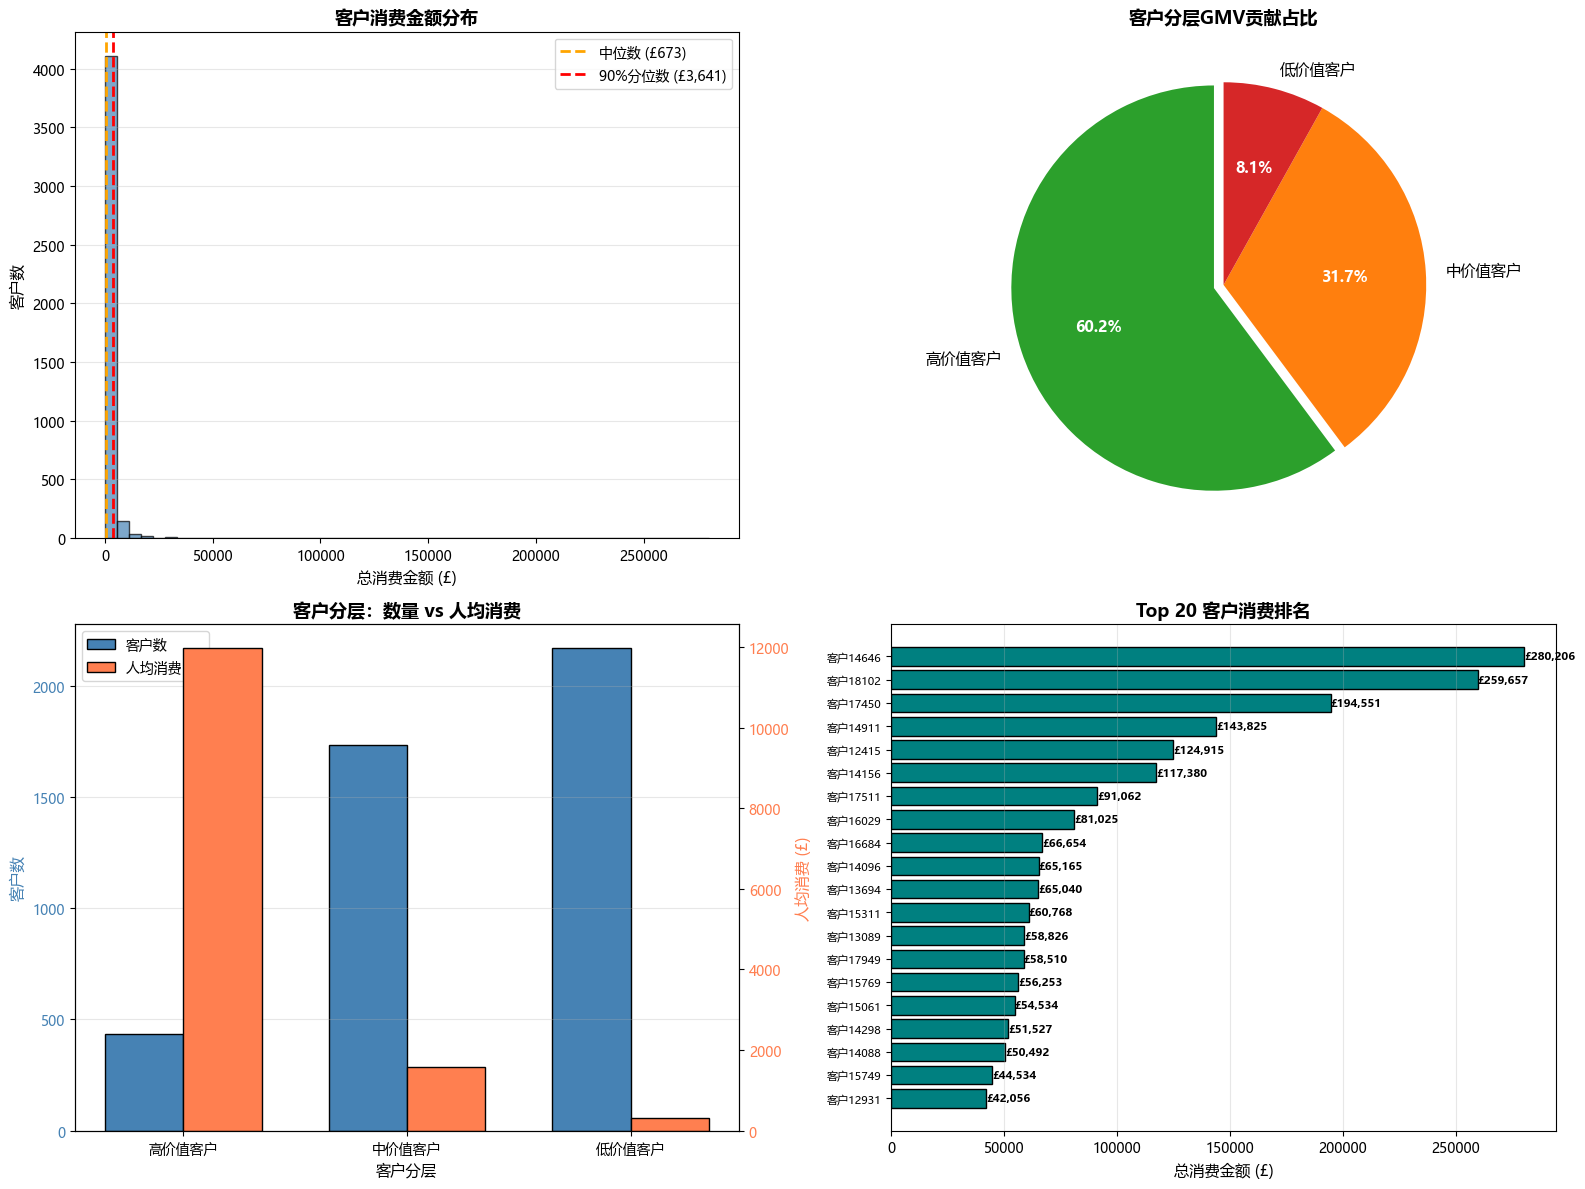

✅ 已保存: viz_5_customer_spending.png


In [45]:
# -------------------- 可视化5：客户消费分布与分层 --------------------
print("\n📊 生成客户消费分布图...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 左上：客户消费金额分布（直方图）
ax1 = axes[0, 0]
ax1.hist(customer_spending['总消费金额'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(threshold_mid, color='orange', linestyle='--', linewidth=2, label=f'中位数 (£{threshold_mid:,.0f})')
ax1.axvline(threshold_high, color='red', linestyle='--', linewidth=2, label=f'90%分位数 (£{threshold_high:,.0f})')
ax1.set_xlabel('总消费金额 (£)', fontsize=11)
ax1.set_ylabel('客户数', fontsize=11)
ax1.set_title('客户消费金额分布', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# 右上：客户分层GMV占比（饼图）
ax2 = axes[0, 1]
colors_pie = ['#2ca02c', '#ff7f0e', '#d62728']
explode = (0.05, 0, 0)
wedges, texts, autotexts = ax2.pie(
    segment_stats['GMV占比(%)'], 
    labels=segment_stats.index, 
    colors=colors_pie,
    autopct='%1.1f%%', 
    startangle=90, 
    explode=explode,
    textprops={'fontsize': 11}
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('客户分层GMV贡献占比', fontsize=13, fontweight='bold')

# 左下：客户分层统计（分组柱状图）
ax3 = axes[1, 0]
x = np.arange(len(segment_stats))
width = 0.35

bars1 = ax3.bar(x - width/2, segment_stats['客户数'], width, label='客户数', color='steelblue', edgecolor='black')
ax3_twin = ax3.twinx()
bars2 = ax3_twin.bar(x + width/2, segment_stats['人均消费'], width, label='人均消费 (£)', color='coral', edgecolor='black')

ax3.set_xlabel('客户分层', fontsize=11)
ax3.set_ylabel('客户数', fontsize=11, color='steelblue')
ax3_twin.set_ylabel('人均消费 (£)', fontsize=11, color='coral')
ax3.set_xticks(x)
ax3.set_xticklabels(segment_stats.index, fontsize=10)
ax3.set_title('客户分层：数量 vs 人均消费', fontsize=13, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='steelblue')
ax3_twin.tick_params(axis='y', labelcolor='coral')
ax3.grid(axis='y', alpha=0.3)

# 图例
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

# 右下：Top 20客户消费排名（水平条形图）
ax4 = axes[1, 1]
top20_customers = customer_spending.nlargest(20, '总消费金额').sort_values('总消费金额', ascending=True)
y_pos = np.arange(len(top20_customers))
bars = ax4.barh(y_pos, top20_customers['总消费金额'], color='teal', edgecolor='black')
ax4.set_yticks(y_pos)
ax4.set_yticklabels([f"客户{int(cid)}" for cid in top20_customers['CustomerID']], fontsize=8)
ax4.set_xlabel('总消费金额 (£)', fontsize=11)
ax4.set_title('Top 20 客户消费排名', fontsize=13, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# 标注消费金额
for i, bar in enumerate(bars):
    width_val = bar.get_width()
    ax4.text(width_val, bar.get_y() + bar.get_height()/2., 
             f'£{width_val:,.0f}', ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_5_customer_spending.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_5_customer_spending.png")

## 指标6：复购率分析

In [55]:
# ==================== 指标6：复购率分析 + 可视化 ====================
print("\n" + "="*80)
print("🔁 指标6：复购率分析".center(80))
print("="*80)

# 复购率计算
customer_spending['是否复购'] = customer_spending['订单数'] > 1
total_customers = len(customer_spending)
repeat_customers = customer_spending['是否复购'].sum()
repeat_rate = (repeat_customers / total_customers) * 100

print(f"\n🔁 复购率分析:")
print(f"- 总客户数: {total_customers:,}")
print(f"- 复购客户数: {repeat_customers:,}")
print(f"- 复购率: {repeat_rate:.2f}%")

# 首购 vs 复购客户价值对比
value_comparison = customer_spending.groupby('是否复购').agg({
    'CustomerID': 'count',
    '总消费金额': ['sum', 'mean'],
    '订单数': 'mean'
}).round(2)

value_comparison.columns = ['客户数', '总GMV', '人均消费', '人均订单数']
print("\n💡 首购 vs 复购客户价值对比:")
print(value_comparison)

repeat_gmv_pct = (value_comparison.loc[True, '总GMV'] / value_comparison['总GMV'].sum()) * 100
print(f"\n复购客户贡献的GMV占比: {repeat_gmv_pct:.2f}%")

# 保存结果
repeat_analysis = pd.DataFrame({
    '指标': ['总客户数', '复购客户数', '复购率(%)', '复购客户GMV占比(%)'],
    '数值': [total_customers, repeat_customers, repeat_rate, repeat_gmv_pct]
})
repeat_analysis.to_csv(os.path.join(save_dir, '6_repeat_rate.csv'), index=False)


                                  🔁 指标6：复购率分析                                   

🔁 复购率分析:
- 总客户数: 4,337
- 复购客户数: 2,844
- 复购率: 65.58%

💡 首购 vs 复购客户价值对比:
        客户数        总GMV     人均消费  人均订单数
是否复购                                   
False  1493   539131.03   361.11   1.00
True   2844  8087653.67  2843.76   5.99

复购客户贡献的GMV占比: 93.75%



📊 生成复购率分析图...


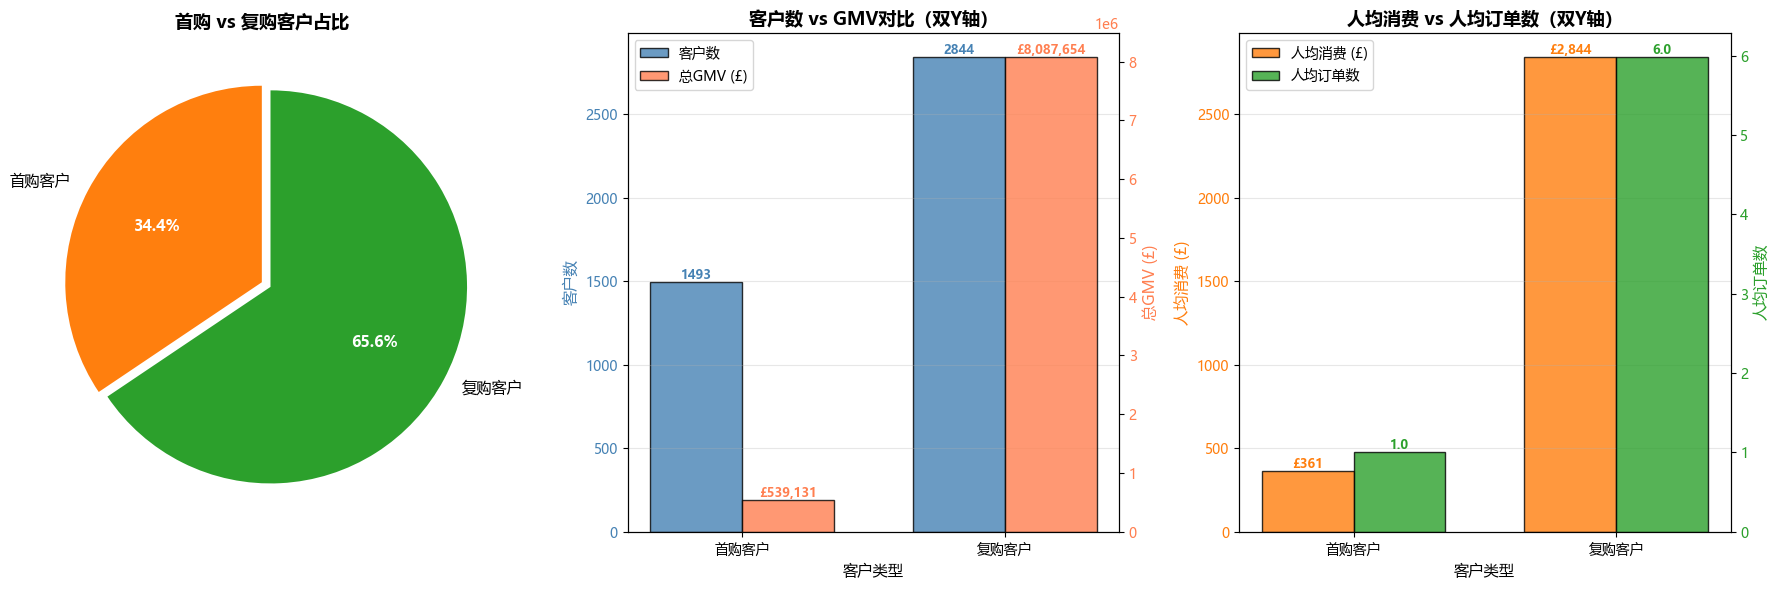

✅ 已保存: viz_6_repeat_analysis.png


In [46]:
# -------------------- 可视化6：复购率分析（优化版）--------------------
print("\n📊 生成复购率分析图...")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 左图：首购 vs 复购客户数量（饼图）- 保持不变
ax1 = axes[0]
labels = ['首购客户', '复购客户']
sizes = [total_customers - repeat_customers, repeat_customers]
colors = ['#ff7f0e', '#2ca02c']
explode = (0, 0.05)
wedges, texts, autotexts = ax1.pie(
    sizes, 
    labels=labels, 
    colors=colors,
    autopct='%1.1f%%', 
    startangle=90, 
    explode=explode,
    textprops={'fontsize': 11}
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax1.set_title('首购 vs 复购客户占比', fontsize=13, fontweight='bold')


# 中图：客户数 vs GMV对比（双Y轴）✅ 修复
ax2 = axes[1]
x_pos = np.arange(2)  # 两组数据：首购、复购
width = 0.35

# 左Y轴：客户数
customer_counts = [value_comparison.loc[False, '客户数'], value_comparison.loc[True, '客户数']]
bars1 = ax2.bar(x_pos - width/2, customer_counts, width, label='客户数', 
                color='steelblue', edgecolor='black', alpha=0.8)
ax2.set_ylabel('客户数', fontsize=11, color='steelblue')
ax2.tick_params(axis='y', labelcolor='steelblue')

# 右Y轴：GMV
ax2_twin = ax2.twinx()
gmv_values = [value_comparison.loc[False, '总GMV'], value_comparison.loc[True, '总GMV']]
bars2 = ax2_twin.bar(x_pos + width/2, gmv_values, width, label='总GMV (£)', 
                     color='coral', edgecolor='black', alpha=0.8)
ax2_twin.set_ylabel('总GMV (£)', fontsize=11, color='coral')
ax2_twin.tick_params(axis='y', labelcolor='coral')

# X轴设置
ax2.set_xlabel('客户类型', fontsize=11)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['首购客户', '复购客户'], fontsize=10)
ax2.set_title('客户数 vs GMV对比（双Y轴）', fontsize=13, fontweight='bold')

# 图例（合并两个Y轴的图例）
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# 标注数值
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='steelblue')

for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2_twin.text(bar.get_x() + bar.get_width()/2., height,
                  f'£{height:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='coral')


# 右图：人均消费 vs 人均订单数（双Y轴）✅ 修复
ax3 = axes[2]
x_pos = np.arange(2)
width = 0.35

# 左Y轴：人均消费
avg_spending = [value_comparison.loc[False, '人均消费'], value_comparison.loc[True, '人均消费']]
bars3 = ax3.bar(x_pos - width/2, avg_spending, width, label='人均消费 (£)', 
                color='#ff7f0e', edgecolor='black', alpha=0.8)
ax3.set_ylabel('人均消费 (£)', fontsize=11, color='#ff7f0e')
ax3.tick_params(axis='y', labelcolor='#ff7f0e')

# 右Y轴：人均订单数
ax3_twin = ax3.twinx()
avg_orders = [value_comparison.loc[False, '人均订单数'], value_comparison.loc[True, '人均订单数']]
bars4 = ax3_twin.bar(x_pos + width/2, avg_orders, width, label='人均订单数', 
                     color='#2ca02c', edgecolor='black', alpha=0.8)
ax3_twin.set_ylabel('人均订单数', fontsize=11, color='#2ca02c')
ax3_twin.tick_params(axis='y', labelcolor='#2ca02c')

# X轴设置
ax3.set_xlabel('客户类型', fontsize=11)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(['首购客户', '复购客户'], fontsize=10)
ax3.set_title('人均消费 vs 人均订单数（双Y轴）', fontsize=13, fontweight='bold')

# 图例
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper left', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 标注数值
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'£{height:,.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='#ff7f0e')

for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax3_twin.text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='#2ca02c')


plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_6_repeat_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_6_repeat_analysis.png")


## 指标7：购买间隔分析

In [21]:
# ==================== 指标7：购买间隔分析 ====================
print("\n" + "="*80)
print("⏱️ 指标7：购买间隔分析".center(80))
print("="*80)

# Step 1: 计算购买间隔
intervals = pd.read_sql_query("""
    SELECT
        CustomerID,
        InvoiceDate as 本次购买日期,
        LAG(InvoiceDate) OVER(
            PARTITION BY CustomerID
            ORDER BY InvoiceDate
        ) as 上次购买日期,
        JULIANDAY(InvoiceDate) - JULIANDAY(LAG(InvoiceDate) OVER(
            PARTITION BY CustomerID
            ORDER BY InvoiceDate
        )) as 间隔天数
    FROM (
        SELECT DISTINCT 
            CustomerID,
            DATE(InvoiceDate) as InvoiceDate
        FROM transactions
    )
""", conn)

intervals_clean = intervals[intervals['间隔天数'].notna()].copy()

# Step 2: 统计整体间隔
print("\n📊 购买间隔统计:")
interval_stats = intervals_clean['间隔天数'].describe()
print(f"- 有效记录数: {len(intervals_clean):,}")
print(f"- 平均间隔: {interval_stats['mean']:.1f} 天")
print(f"- 中位数间隔: {interval_stats['50%']:.1f} 天")
print(f"- 最短间隔: {interval_stats['min']:.1f} 天")
print(f"- 最长间隔: {interval_stats['max']:.1f} 天")

# Step 3: 间隔分布
interval_distribution = pd.cut(
    intervals_clean['间隔天数'],
    bins=[0, 7, 30, 60, 90, float('inf')],
    labels=['0-7天', '8-30天', '31-60天', '61-90天', '>90天']
).value_counts().sort_index()

interval_pct = (interval_distribution / len(intervals_clean) * 100).round(1)
interval_summary = pd.DataFrame({
    '频次': interval_distribution,
    '占比(%)': interval_pct
})
print("\n📋 购买间隔分布:")
print(interval_summary.to_string())

# Step 4: 快速复购
fast_repurchase_count = len(intervals_clean[intervals_clean['间隔天数'] <= 30])
fast_repurchase_ratio = (fast_repurchase_count / len(intervals_clean)) * 100
print(f"\n⚡ 快速复购（间隔≤30天）: {fast_repurchase_count:,} ({fast_repurchase_ratio:.1f}%)")

# Step 5: 沉默客户
latest_date = pd.to_datetime(intervals['本次购买日期'].max())
customer_latest = intervals.groupby('CustomerID')['本次购买日期'].max().reset_index()
customer_latest['本次购买日期'] = pd.to_datetime(customer_latest['本次购买日期'])
customer_latest['距今天数'] = (latest_date - customer_latest['本次购买日期']).dt.days

silent_customers = customer_latest[customer_latest['距今天数'] > 90]
silent_count = len(silent_customers)
silent_ratio = (silent_count / len(customer_latest)) * 100

print(f"\n😴 沉默客户（>90天未购买）: {silent_count:,} ({silent_ratio:.1f}%)")

# 高价值沉默客户
silent_with_value = silent_customers.merge(customer_spending, on='CustomerID')
high_value_silent = silent_with_value[silent_with_value['总消费金额'] > threshold_high]

print(f"\n⚠️ 高价值沉默客户: {len(high_value_silent):,}")
print(f"   潜在流失GMV: £{high_value_silent['总消费金额'].sum():,.2f}")

# Step 6: 各客户群体平均间隔
avg_interval_by_customer = intervals_clean.groupby('CustomerID')['间隔天数'].mean().reset_index()
avg_interval_by_customer.columns = ['CustomerID', '平均购买间隔']

customer_segment = customer_spending[['CustomerID', '客户分层']]
interval_by_segment = avg_interval_by_customer.merge(customer_segment, on='CustomerID')

segment_interval = interval_by_segment.groupby('客户分层')['平均购买间隔'].agg(['mean', 'median', 'count']).round(1)
segment_interval.columns = ['平均间隔(天)', '中位数间隔(天)', '客户数']

print("\n📊 不同客户群体的购买间隔:")
print(segment_interval.to_string())

# 保存结果
intervals_clean.to_csv(os.path.join(save_dir, '7_purchase_intervals.csv'), index=False)
customer_latest.to_csv(os.path.join(save_dir, '7_customer_status.csv'), index=False)
silent_customers.to_csv(os.path.join(save_dir, '7_silent_customers.csv'), index=False)


                                 ⏱️ 指标7：购买间隔分析                                  

📊 购买间隔统计:
- 有效记录数: 12,424
- 平均间隔: 45.6 天
- 中位数间隔: 28.0 天
- 最短间隔: 1.0 天
- 最长间隔: 366.0 天

📋 购买间隔分布:
          频次  占比(%)
间隔天数               
0-7天    2148   17.3
8-30天   4478   36.0
31-60天  2846   22.9
61-90天  1200    9.7
>90天    1752   14.1

⚡ 快速复购（间隔≤30天）: 6,626 (53.3%)

😴 沉默客户（>90天未购买）: 1,449 (33.4%)

⚠️ 高价值沉默客户: 21
   潜在流失GMV: £150,969.94

📊 不同客户群体的购买间隔:
       平均间隔(天)  中位数间隔(天)   客户数
客户分层                          
中价值客户     73.9      60.9  1584
低价值客户    109.6      86.0   779
高价值客户     37.9      29.7   426



📊 生成购买间隔分析图...


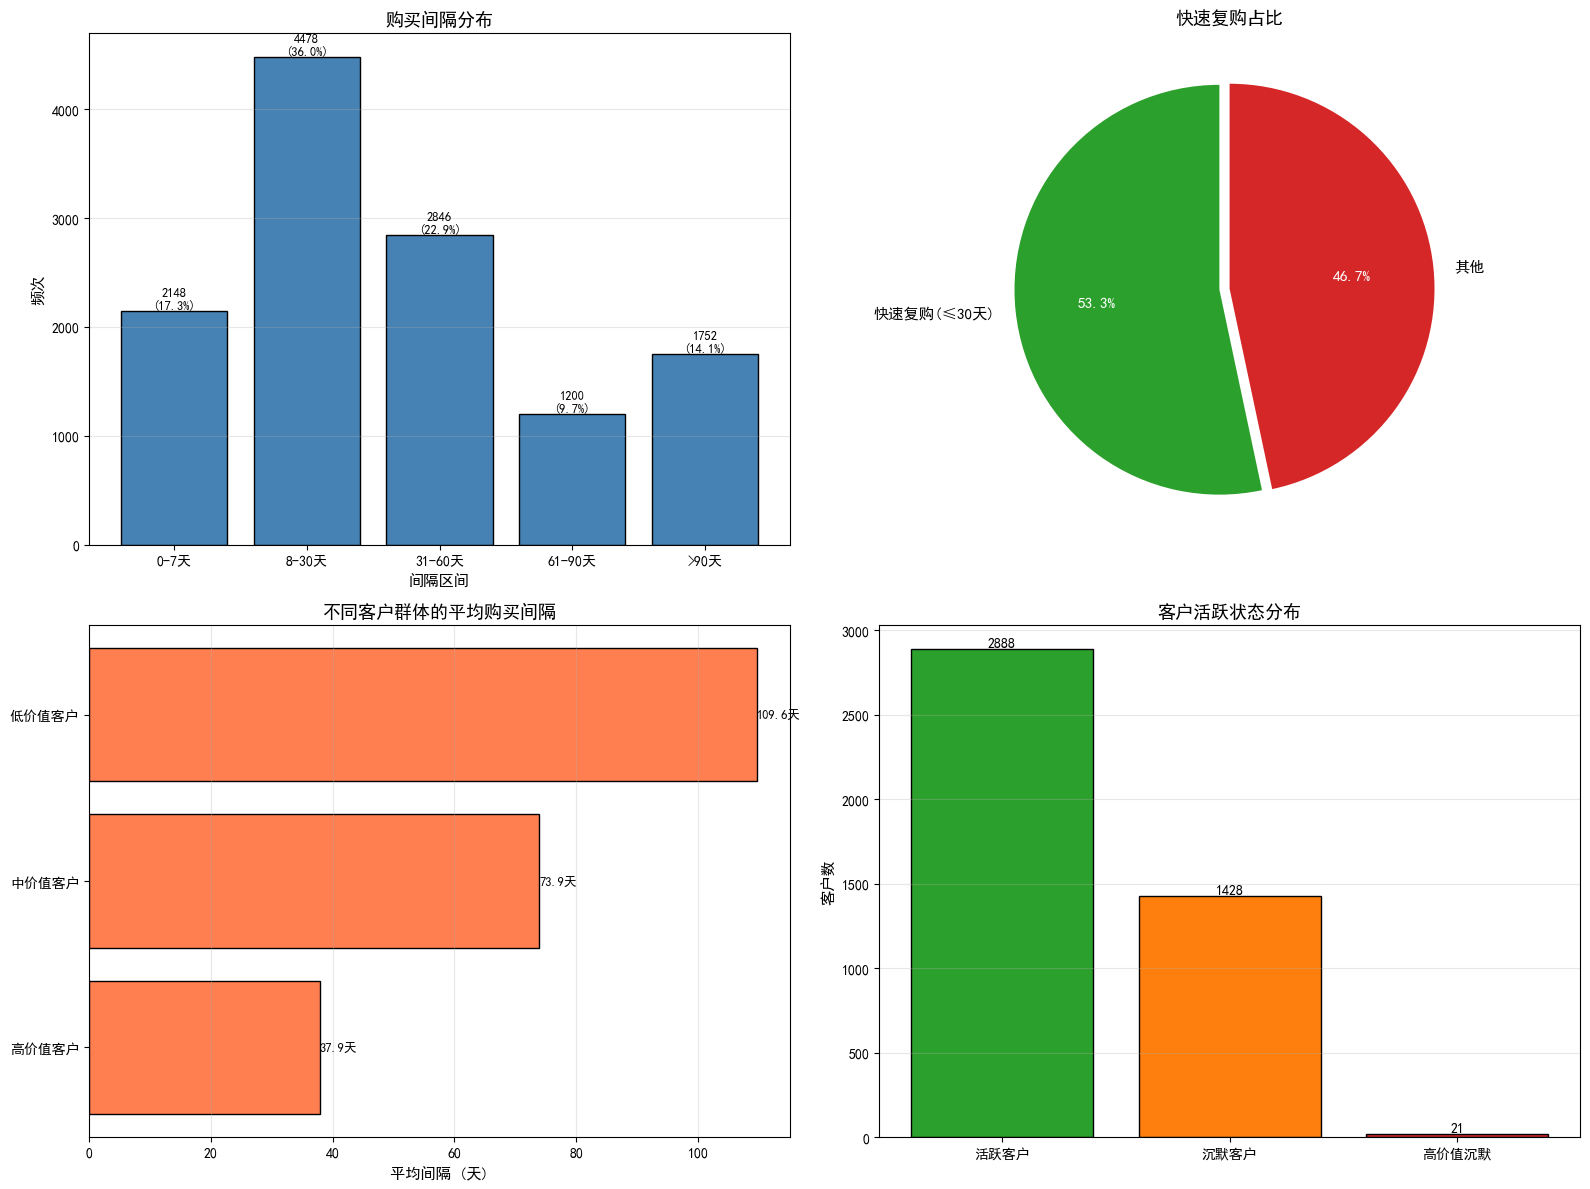

✅ 已保存: viz_7_interval_analysis.png


In [22]:
# -------------------- 可视化7：购买间隔分析 --------------------
print("\n📊 生成购买间隔分析图...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 左上：购买间隔分布（柱状图）
ax1 = axes[0, 0]
bars = ax1.bar(interval_summary.index, interval_summary['频次'], color='steelblue', edgecolor='black')
ax1.set_xlabel('间隔区间', fontsize=11)
ax1.set_ylabel('频次', fontsize=11)
ax1.set_title('购买间隔分布', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 标注占比
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = interval_summary.iloc[i]['占比(%)']
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({pct}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 右上：快速复购 vs 其他（饼图）
ax2 = axes[0, 1]
labels = ['快速复购(≤30天)', '其他']
sizes = [fast_repurchase_count, len(intervals_clean) - fast_repurchase_count]
colors = ['#2ca02c', '#d62728']
explode = (0.05, 0)
wedges, texts, autotexts = ax2.pie(
    sizes, 
    labels=labels, 
    colors=colors,
    autopct='%1.1f%%', 
    startangle=90, 
    explode=explode,
    textprops={'fontsize': 11}
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('快速复购占比', fontsize=13, fontweight='bold')

# 左下：不同客户群体平均间隔（水平条形图）
ax3 = axes[1, 0]
segment_interval_sorted = segment_interval.sort_values('平均间隔(天)', ascending=True)
y_pos = np.arange(len(segment_interval_sorted))
bars = ax3.barh(y_pos, segment_interval_sorted['平均间隔(天)'], color='coral', edgecolor='black')
ax3.set_yticks(y_pos)
ax3.set_yticklabels(segment_interval_sorted.index, fontsize=10)
ax3.set_xlabel('平均间隔 (天)', fontsize=11)
ax3.set_title('不同客户群体的平均购买间隔', fontsize=13, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 标注数值
for i, bar in enumerate(bars):
    width_val = bar.get_width()
    ax3.text(width_val, bar.get_y() + bar.get_height()/2., 
             f'{width_val:.1f}天', ha='left', va='center', fontsize=9, fontweight='bold')

# 右下：沉默客户状态（堆叠柱状图）
ax4 = axes[1, 1]
silent_status = pd.DataFrame({
    '类型': ['活跃客户', '沉默客户', '高价值沉默'],
    '数量': [
        len(customer_latest) - silent_count,
        silent_count - len(high_value_silent),
        len(high_value_silent)
    ]
})
colors_status = ['#2ca02c', '#ff7f0e', '#d62728']
bars = ax4.bar(silent_status['类型'], silent_status['数量'], color=colors_status, edgecolor='black')
ax4.set_ylabel('客户数', fontsize=11)
ax4.set_title('客户活跃状态分布', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 标注数值
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_7_interval_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_7_interval_analysis.png")

## 指标8：RFM客户分层

In [23]:
# ==================== 指标8：RFM客户分层====================
print("\n" + "="*80)
print("🎯 指标8：RFM客户分层".center(80))
print("="*80)

# 计算基准日期
snapshot_data = pd.to_datetime(customer_spending['最近购买日期'].max()) + pd.Timedelta(days=1)

# 计算RFM
rfm = customer_spending.copy()
rfm['Recency'] = (snapshot_data - pd.to_datetime(rfm['最近购买日期'])).dt.days
rfm['Frequency'] = rfm['订单数']
rfm['Monetary'] = rfm['总消费金额']

# RFM评分
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])  # R越小越好
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# 客户分群
def segment_customer(row):
    r, f, m = int(row['R_score']), int(row['F_score']), int(row['M_score'])
    if r >= 3 and f >= 3 and m >= 3:
        return '冠军客户'
    elif r >= 3 and f >= 2:
        return '忠诚客户'
    elif r >= 3 and m >= 3:
        return '大额新客户'
    elif r >= 2 and f >= 2:
        return '潜力客户'
    elif r <= 2 and f >= 3:
        return '沉睡客户'
    elif r <= 2 and f <= 2:
        return '流失客户'
    else:
        return '一般客户'

rfm['客户群体'] = rfm.apply(segment_customer, axis=1)

# 分群统计
segment_stats_rfm = rfm.groupby('客户群体').agg({
    'CustomerID': 'count',
    'Monetary': ['sum', 'mean'],
    'Frequency': 'mean',
    'Recency': 'mean'
}).round(2)

segment_stats_rfm.columns = ['客户数', '总GMV', '人均消费', '平均购买次数', '平均间隔天数']
segment_stats_rfm['客户占比(%)'] = (segment_stats_rfm['客户数'] / len(rfm) * 100).round(1)
segment_stats_rfm['GMV占比(%)'] = (segment_stats_rfm['总GMV'] / segment_stats_rfm['总GMV'].sum() * 100).round(1)
segment_stats_rfm = segment_stats_rfm.sort_values('总GMV', ascending=False)

print("\n🎯 RFM客户分群结果:")
print(segment_stats_rfm.to_string())

# 保存结果
rfm.to_csv(os.path.join(save_dir, '8_rfm_analysis.csv'), index=False)
segment_stats_rfm.to_csv(os.path.join(save_dir, '8_rfm_segments.csv'))


                                 🎯 指标8：RFM客户分层                                  

🎯 RFM客户分群结果:
        客户数        总GMV     人均消费  平均购买次数  平均间隔天数  客户占比(%)  GMV占比(%)
客户群体                                                               
冠军客户   1319  6506541.99  4932.94    9.38   17.09     30.4      75.4
潜力客户    759   955224.80  1258.53    3.30   83.96     17.5      11.1
流失客户   1211   505304.33   417.26    1.16  211.69     27.9       5.9
忠诚客户    609   336198.33   552.05    2.18   23.40     14.0       3.9
沉睡客户    180   231399.70  1285.55    3.72  207.75      4.2       2.7
一般客户    241    67715.04   280.98    1.00   27.07      5.6       0.8
大额新客户    18    24400.51  1355.58    1.00   27.39      0.4       0.3



📊 生成RFM客户分层图...


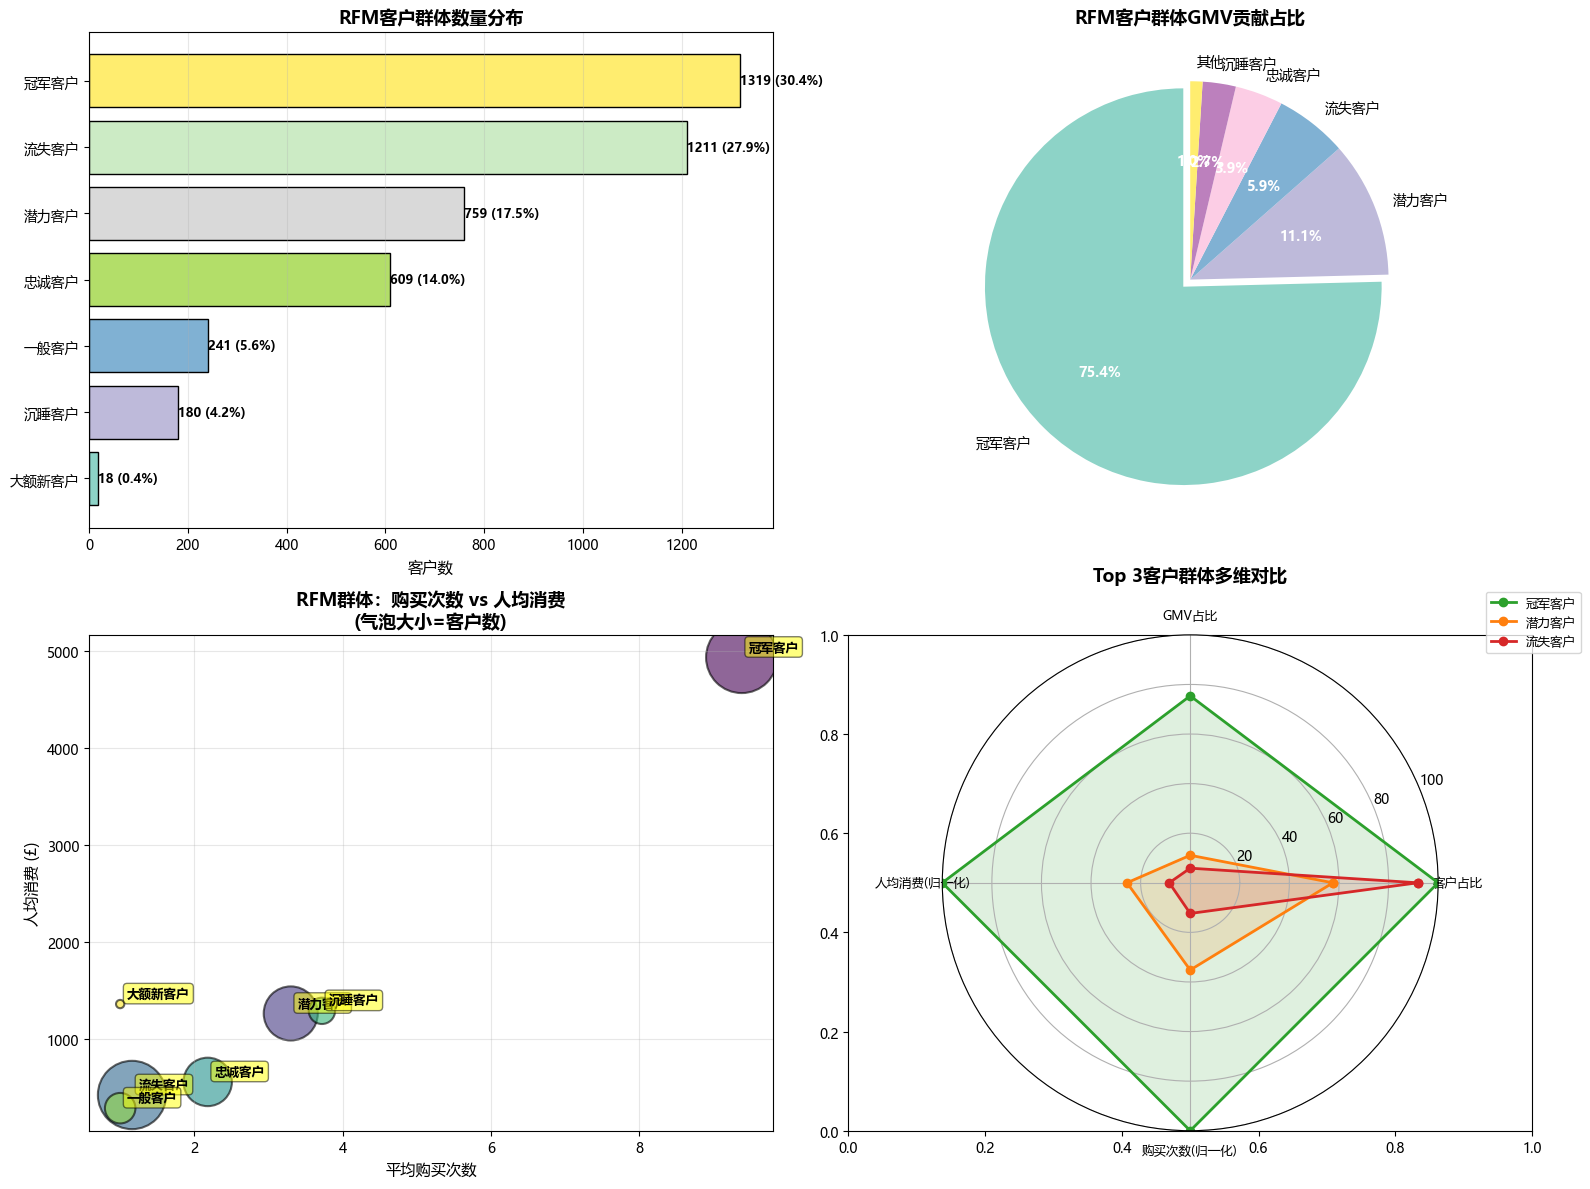

✅ 已保存: viz_8_rfm_segments.png


In [47]:
# -------------------- 可视化8：RFM客户分层 --------------------
print("\n📊 生成RFM客户分层图...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 左上：客户群体数量分布（水平条形图）
ax1 = axes[0, 0]
segment_sorted = segment_stats_rfm.sort_values('客户数', ascending=True)
y_pos = np.arange(len(segment_sorted))
colors_segment = plt.cm.Set3(np.linspace(0, 1, len(segment_sorted)))
bars = ax1.barh(y_pos, segment_sorted['客户数'], color=colors_segment, edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(segment_sorted.index, fontsize=10)
ax1.set_xlabel('客户数', fontsize=11)
ax1.set_title('RFM客户群体数量分布', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 标注数值和占比
for i, bar in enumerate(bars):
    width_val = bar.get_width()
    pct = segment_sorted.iloc[i]['客户占比(%)']
    ax1.text(width_val, bar.get_y() + bar.get_height()/2., 
             f'{int(width_val)} ({pct}%)', ha='left', va='center', fontsize=9, fontweight='bold')

# 右上：GMV贡献占比（饼图）
ax2 = axes[0, 1]
top5_segments = segment_stats_rfm.nlargest(5, 'GMV占比(%)')
other_gmv = 100 - top5_segments['GMV占比(%)'].sum()
labels = list(top5_segments.index) + ['其他']
sizes = list(top5_segments['GMV占比(%)']) + [other_gmv]
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(sizes)))
explode = [0.05 if label == '冠军客户' else 0 for label in labels]

wedges, texts, autotexts = ax2.pie(
    sizes, 
    labels=labels, 
    colors=colors_pie,
    autopct='%1.1f%%', 
    startangle=90, 
    explode=explode,
    textprops={'fontsize': 10}
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('RFM客户群体GMV贡献占比', fontsize=13, fontweight='bold')

# 左下：人均消费 vs 平均购买次数（散点图）
ax3 = axes[1, 0]
scatter = ax3.scatter(
    segment_stats_rfm['平均购买次数'], 
    segment_stats_rfm['人均消费'],
    s=segment_stats_rfm['客户数']*2,  # 气泡大小
    c=range(len(segment_stats_rfm)),
    cmap='viridis',
    alpha=0.6,
    edgecolors='black',
    linewidth=1.5
)
ax3.set_xlabel('平均购买次数', fontsize=11)
ax3.set_ylabel('人均消费 (£)', fontsize=11)
ax3.set_title('RFM群体：购买次数 vs 人均消费\n(气泡大小=客户数)', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3)

# 标注群体名称
for idx, row in segment_stats_rfm.iterrows():
    ax3.annotate(idx, 
                 (row['平均购买次数'], row['人均消费']),
                 xytext=(5, 5), 
                 textcoords='offset points', 
                 fontsize=9, 
                 fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# 右下：RFM群体对比雷达图（多维度）
ax4 = axes[1, 1]
categories = ['客户占比', 'GMV占比', '人均消费(归一化)', '购买次数(归一化)']
top3_segments = segment_stats_rfm.nlargest(3, '总GMV')

# 数据归一化
normalized_data = []
for idx, row in top3_segments.iterrows():
    values = [
        row['客户占比(%)'] / segment_stats_rfm['客户占比(%)'].max() * 100,
        row['GMV占比(%)'],
        row['人均消费'] / segment_stats_rfm['人均消费'].max() * 100,
        row['平均购买次数'] / segment_stats_rfm['平均购买次数'].max() * 100
    ]
    normalized_data.append(values)

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
normalized_data = [row + row[:1] for row in normalized_data]  # 闭合
angles += angles[:1]

ax4 = plt.subplot(224, polar=True)
colors_radar = ['#2ca02c', '#ff7f0e', '#d62728']
for i, (values, label) in enumerate(zip(normalized_data, top3_segments.index)):
    ax4.plot(angles, values, 'o-', linewidth=2, label=label, color=colors_radar[i])
    ax4.fill(angles, values, alpha=0.15, color=colors_radar[i])

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories, fontsize=9)
ax4.set_ylim(0, 100)
ax4.set_title('Top 3客户群体多维对比', fontsize=13, fontweight='bold', pad=20)
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
ax4.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_8_rfm_segments.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_8_rfm_segments.png")

## 指标9：留存率分析

In [26]:
# ==================== 指标9：留存率分析 ====================
print("\n" + "="*80)
print("📈 指标9：留存率分析".center(80))
print("="*80)

# 1. 获取首次购买月份
first_purchase = pd.read_sql_query("""
    SELECT 
        CustomerID,
        MIN(InvoiceDate) as first_purchase_date
    FROM transactions
    GROUP BY CustomerID
""", conn)

first_purchase['first_purchase_date'] = pd.to_datetime(first_purchase['first_purchase_date'])
first_purchase['cohort_month'] = first_purchase['first_purchase_date'].dt.to_period('M')

# 2. 获取所有交易记录
all_purchases = pd.read_sql_query("""
    SELECT CustomerID, InvoiceDate
    FROM transactions
""", conn)

all_purchases['InvoiceDate'] = pd.to_datetime(all_purchases['InvoiceDate'])
all_purchases['purchase_month'] = all_purchases['InvoiceDate'].dt.to_period('M')

# 3. 合并并计算period_number
cohort_data = all_purchases.merge(first_purchase, on='CustomerID')
cohort_data['period_number'] = (cohort_data['purchase_month'] - cohort_data['cohort_month']).apply(lambda x: x.n)

# 4. 计算留存率矩阵
cohort_counts = cohort_data.groupby(['cohort_month', 'period_number'])['CustomerID'].nunique().reset_index()
cohort_counts.columns = ['cohort_month', 'period_number', 'active_users']
retention_table = cohort_counts.pivot(index='cohort_month', columns='period_number', values='active_users')
retention_rate = (retention_table.divide(retention_table[0], axis=0) * 100).round(1)

print("\n📈 留存率矩阵 (%):")
print(retention_rate.iloc[:, :6].to_string())

# 5. 平均留存率
if 1 in retention_rate.columns:
    month_1_retention = retention_rate[1].mean()
    print(f"\n💡 平均1个月留存率: {month_1_retention:.1f}%")
if 2 in retention_rate.columns:
    month_2_retention = retention_rate[2].mean()
    print(f"💡 平均2个月留存率: {month_2_retention:.1f}%")
if 3 in retention_rate.columns:
    month_3_retention = retention_rate[3].mean()
    print(f"💡 平均3个月留存率: {month_3_retention:.1f}%")

# 保存结果
retention_rate.to_csv(os.path.join(save_dir, '9_retention_matrix.csv'))



                                  📈 指标9：留存率分析                                   

📈 留存率矩阵 (%):
period_number      0     1     2     3     4     5
cohort_month                                      
2010-12        100.0  36.6  32.3  38.4  36.3  39.8
2011-01        100.0  22.1  26.7  23.1  32.2  28.8
2011-02        100.0  18.7  18.7  28.4  27.1  24.7
2011-03        100.0  15.0  25.2  19.9  22.3  16.8
2011-04        100.0  21.3  20.3  21.0  19.7  22.7
2011-05        100.0  19.0  17.3  17.3  20.8  23.2
2011-06        100.0  17.4  15.7  26.4  23.1  33.5
2011-07        100.0  18.1  20.7  22.3  27.1  11.2
2011-08        100.0  20.7  24.9  24.3  12.4   NaN
2011-09        100.0  23.4  30.1  11.4   NaN   NaN
2011-10        100.0  24.0  11.5   NaN   NaN   NaN
2011-11        100.0  11.1   NaN   NaN   NaN   NaN
2011-12        100.0   NaN   NaN   NaN   NaN   NaN

💡 平均1个月留存率: 20.6%
💡 平均2个月留存率: 22.1%
💡 平均3个月留存率: 23.3%



📊 生成留存率分析图...


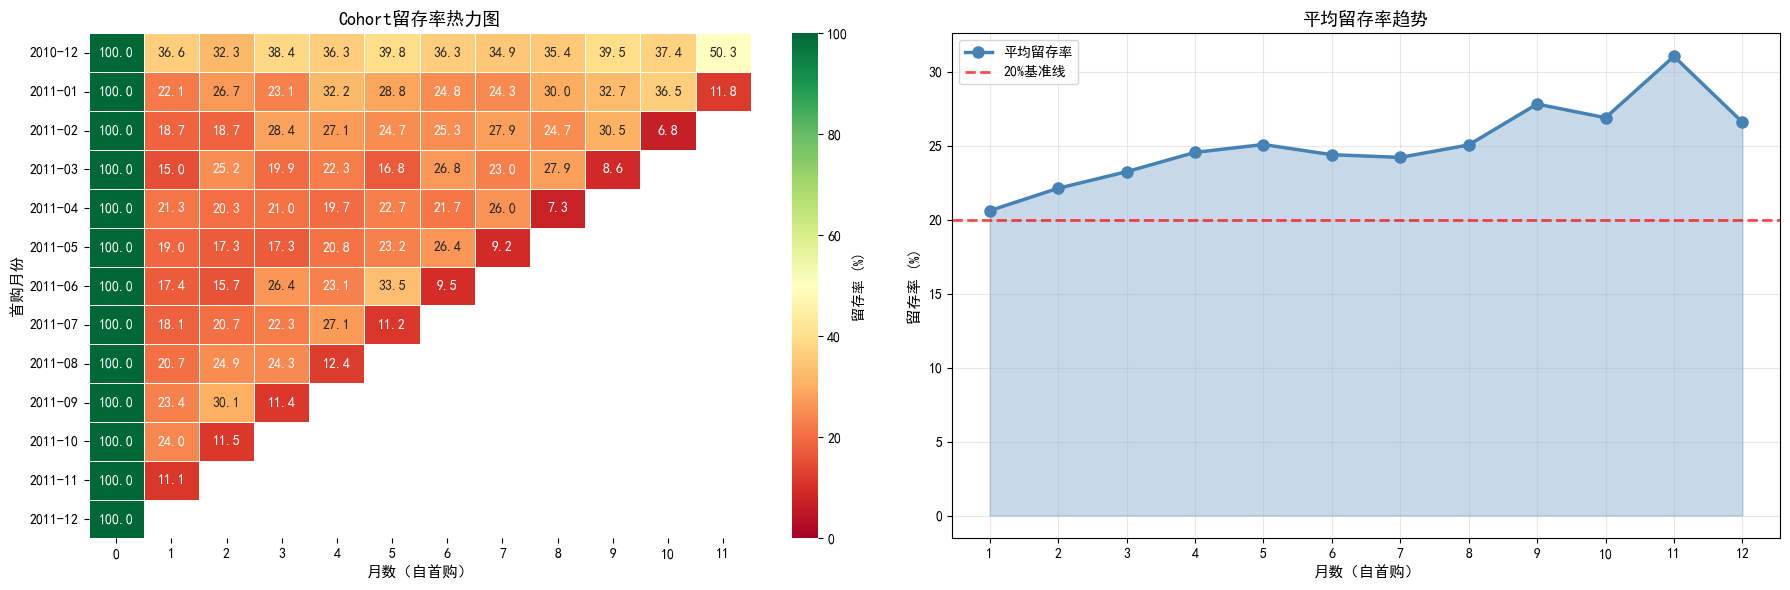

✅ 已保存: viz_9_retention_analysis.png


In [27]:
# -------------------- 可视化9：留存率分析 --------------------
print("\n📊 生成留存率分析图...")

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 左图：留存率热力图
ax1 = axes[0]
retention_display = retention_rate.iloc[:, :12]  # 显示前12个月
sns.heatmap(
    retention_display, 
    annot=True, 
    fmt='.1f', 
    cmap='RdYlGn', 
    cbar_kws={'label': '留存率 (%)'}, 
    linewidths=0.5, 
    ax=ax1,
    vmin=0,
    vmax=100
)
ax1.set_xlabel('月数（自首购）', fontsize=11)
ax1.set_ylabel('首购月份', fontsize=11)
ax1.set_title('Cohort留存率热力图', fontsize=13, fontweight='bold')

# 右图：平均留存率趋势线
ax2 = axes[1]
avg_retention = retention_rate.iloc[:, 1:13].mean()  # 1-12月平均
months = range(1, len(avg_retention) + 1)
ax2.plot(months, avg_retention.values, marker='o', linewidth=2.5, markersize=8, color='steelblue', label='平均留存率')
ax2.fill_between(months, avg_retention.values, alpha=0.3, color='steelblue')
ax2.axhline(y=20, color='red', linestyle='--', linewidth=2, alpha=0.7, label='20%基准线')
ax2.set_xlabel('月数（自首购）', fontsize=11)
ax2.set_ylabel('留存率 (%)', fontsize=11)
ax2.set_title('平均留存率趋势', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(months)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_9_retention_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_9_retention_analysis.png")

## 指标10：客户生命周期价值（LTV）估算

In [28]:
# ==================== 指标10：客户生命周期价值（LTV）+ 可视化 ====================
print("\n" + "="*80)
print("💎 指标10：客户生命周期价值（LTV）".center(80))
print("="*80)

# 计算生命周期
customer_lifetime = pd.read_sql_query("""
    SELECT
        CustomerID,
        ROUND(JULIANDAY(MAX(InvoiceDate)) - JULIANDAY(MIN(InvoiceDate))) as lifecycle_days,
        COUNT(DISTINCT Date) as active_days
    FROM transactions
    GROUP BY CustomerID;
""", conn)

customer_lifetime['lifecycle_months'] = customer_lifetime['lifecycle_days'] / 30

# 合并RFM数据
ltv_data = rfm[['CustomerID', 'Frequency', 'Monetary', '客户群体']].merge(
    customer_lifetime, on='CustomerID'
)

# 计算LTV
ltv_data['avg_order_value'] = ltv_data['Monetary'] / ltv_data['Frequency']
ltv_data['estimated_LTV'] = (
    ltv_data['avg_order_value'] *
    ltv_data['Frequency'] *
    ltv_data['lifecycle_months']
).round(2)

print("\n💎 客户LTV统计:")
print(ltv_data[['CustomerID', 'Monetary', 'Frequency', 'lifecycle_months', 'estimated_LTV']].head(10).to_string(index=False))

# 按客户群体分析
ltv_by_segment = ltv_data.groupby('客户群体').agg({
    'estimated_LTV': ['mean', 'median', 'sum'],
    'CustomerID': 'count'
}).round(2)

ltv_by_segment.columns = ['平均LTV', '中位数LTV', '累计LTV', '客户数']
ltv_by_segment['LTV占比(%)'] = (ltv_by_segment['累计LTV'] / ltv_by_segment['累计LTV'].sum() * 100).round(1)
ltv_by_segment = ltv_by_segment.sort_values('平均LTV', ascending=False)

print("\n🎯 不同客户群体的LTV:")
print(ltv_by_segment.to_string())

# 保存结果
ltv_data.to_csv(os.path.join(save_dir, '10_customer_ltv.csv'), index=False)



                              💎 指标10：客户生命周期价值（LTV）                              

💎 客户LTV统计:
 CustomerID  Monetary  Frequency  lifecycle_months  estimated_LTV
    12347.0   4310.00          7         12.166667       52438.33
    12348.0   1797.24          4          9.433333       16953.96
    12349.0   1757.55          1          0.000000           0.00
    12350.0    334.40          1          0.000000           0.00
    12352.0   2506.04          8          8.666667       21719.01
    12353.0     89.00          1          0.000000           0.00
    12354.0   1079.40          1          0.000000           0.00
    12355.0    459.40          1          0.000000           0.00
    12356.0   2811.43          3         10.100000       28395.44
    12357.0   6207.67          1          0.000000           0.00

🎯 不同客户群体的LTV:
          平均LTV    中位数LTV        累计LTV   客户数  LTV占比(%)
客户群体                                                  
冠军客户   51484.63  19154.66  67908223.70  1319      88.8



📊 生成LTV分析图...


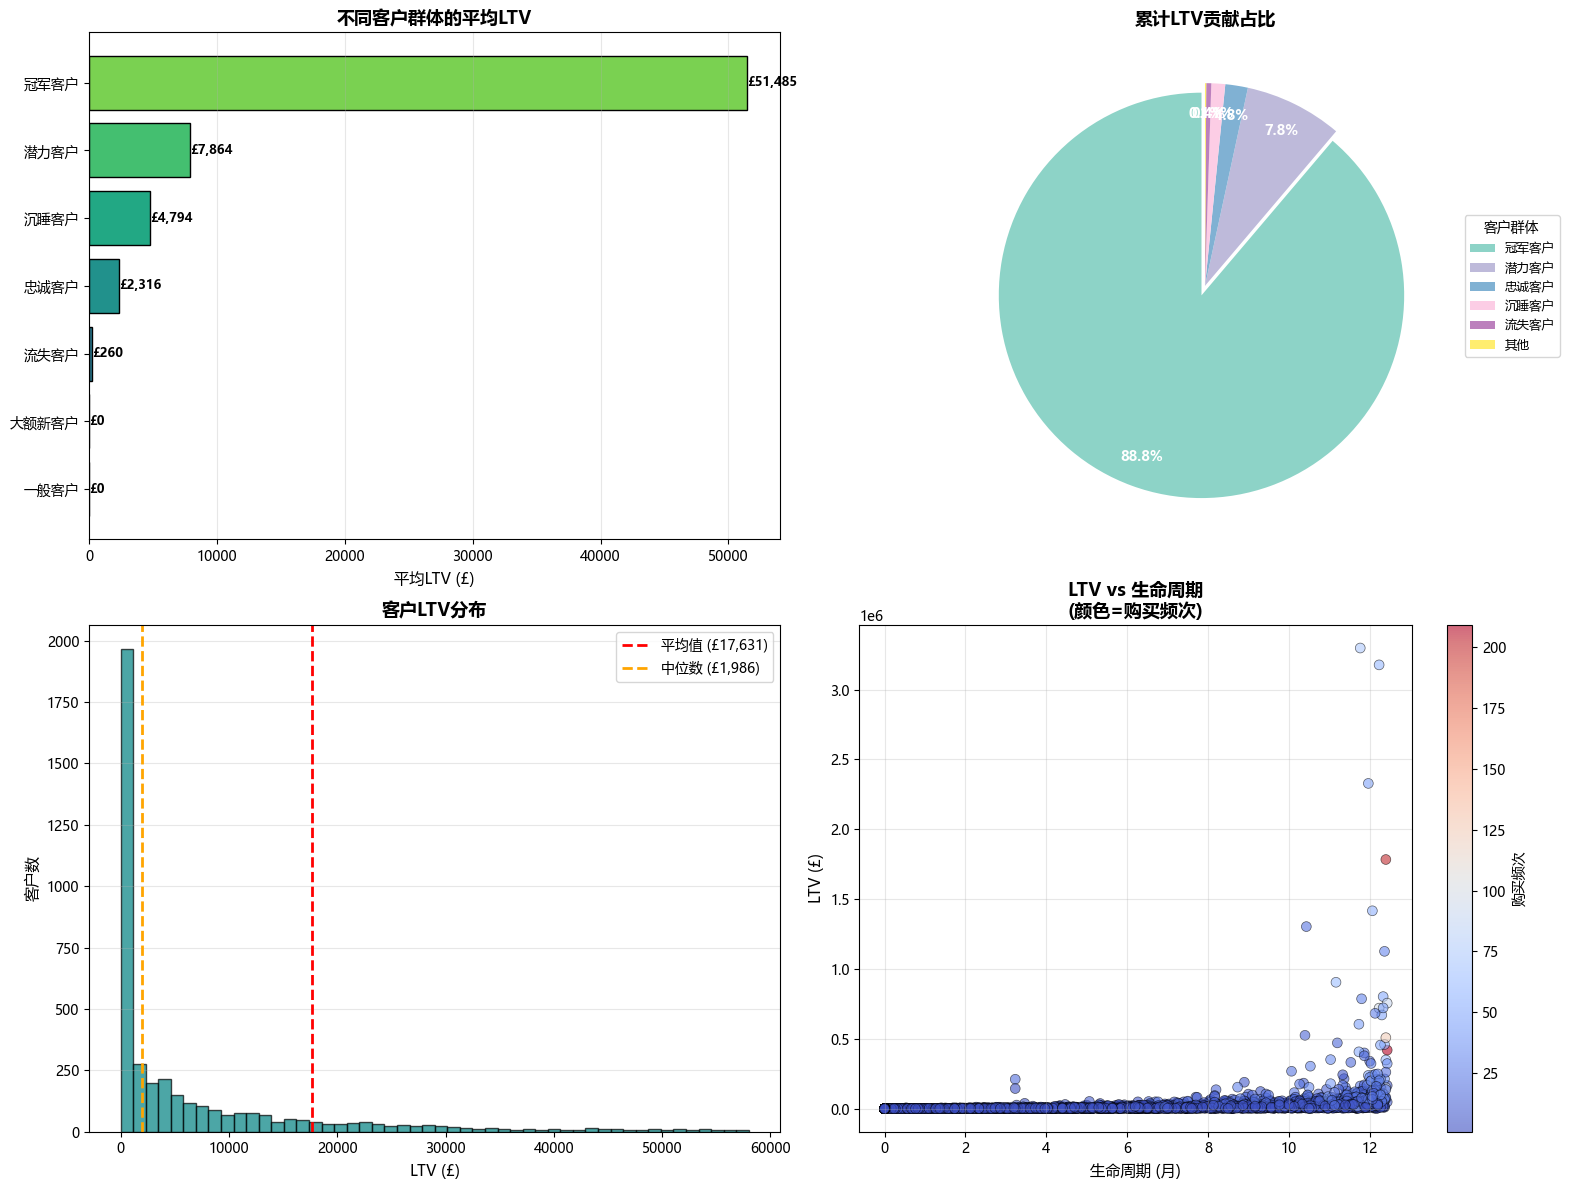

✅ 已保存: viz_10_ltv_analysis.png

                                 ✅ 客户价值深度分析已完成！                                 

📁 保存位置: D:\Postgraduate\工作\stage 1\archive\results

📊 生成文件:
   数据文件:
   ├── 5_customer_spending.csv       (客户消费数据)
   ├── 5_segment_stats.csv           (客户分层统计)
   ├── 6_repeat_rate.csv             (复购率分析)
   ├── 7_purchase_intervals.csv      (购买间隔数据)
   ├── 7_customer_status.csv         (客户状态)
   ├── 7_silent_customers.csv        (沉默客户)
   ├── 8_rfm_analysis.csv            (RFM分析)
   ├── 8_rfm_segments.csv            (RFM分群统计)
   ├── 9_retention_matrix.csv        (留存率矩阵)
   └── 10_customer_ltv.csv           (客户LTV)

   可视化文件:
   ├── viz_5_customer_spending.png   (客户消费分布)
   ├── viz_6_repeat_analysis.png     (复购率分析)
   ├── viz_7_interval_analysis.png   (购买间隔分析)
   ├── viz_8_rfm_segments.png        (RFM客户分层)
   ├── viz_9_retention_analysis.png  (留存率分析)
   └── viz_10_ltv_analysis.png       (LTV分析)

💡 核心发现:
   1. 客户价值高度集中，Top 10%贡献60.2% GMV
   2. 复购率65.58%，复购客户贡献93.8% GMV
   3

In [52]:
# -------------------- 可视化10：LTV分析 --------------------
print("\n📊 生成LTV分析图...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 左上：不同群体平均LTV（水平条形图）
ax1 = axes[0, 0]
ltv_sorted = ltv_by_segment.sort_values('平均LTV', ascending=True)
y_pos = np.arange(len(ltv_sorted))
colors_ltv = plt.cm.viridis(np.linspace(0.2, 0.8, len(ltv_sorted)))
bars = ax1.barh(y_pos, ltv_sorted['平均LTV'], color=colors_ltv, edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(ltv_sorted.index, fontsize=10)
ax1.set_xlabel('平均LTV (£)', fontsize=11)
ax1.set_title('不同客户群体的平均LTV', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 标注数值
for i, bar in enumerate(bars):
    width_val = bar.get_width()
    ax1.text(width_val, bar.get_y() + bar.get_height()/2., 
             f'£{width_val:,.0f}', ha='left', va='center', fontsize=9, fontweight='bold')

# 右上：累计LTV贡献占比（饼图）
ax2 = axes[0, 1]
top5_ltv = ltv_by_segment.nlargest(5, 'LTV占比(%)')
other_ltv = 100 - top5_ltv['LTV占比(%)'].sum()
labels = list(top5_ltv.index) + ['其他']
sizes = list(top5_ltv['LTV占比(%)']) + [other_ltv]
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(sizes)))
explode = [0.05 if label == '冠军客户' else 0 for label in labels]

wedges, texts, autotexts = ax2.pie(
    sizes, 
    labels=None,  # ✅ 不在饼图上显示标签
    colors=colors_pie,
    autopct='%1.1f%%', 
    pctdistance=0.85,
    startangle=90, 
    explode=explode,
    textprops={'fontsize': 10}
)

# 设置百分比文字样式
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# ✅ 使用图例显示分类名称
ax2.legend(wedges, labels, 
          title="客户群体",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),  # 放在图的右侧
          fontsize=9)

ax2.set_title('累计LTV贡献占比', fontsize=13, fontweight='bold')


# 左下：LTV分布（直方图）
ax3 = axes[1, 0]
ltv_filtered = ltv_data[ltv_data['estimated_LTV'] < ltv_data['estimated_LTV'].quantile(0.95)]  # 过滤极端值
ax3.hist(ltv_filtered['estimated_LTV'], bins=50, color='teal', edgecolor='black', alpha=0.7)
ax3.axvline(ltv_data['estimated_LTV'].mean(), color='red', linestyle='--', linewidth=2, label=f"平均值 (£{ltv_data['estimated_LTV'].mean():,.0f})")
ax3.axvline(ltv_data['estimated_LTV'].median(), color='orange', linestyle='--', linewidth=2, label=f"中位数 (£{ltv_data['estimated_LTV'].median():,.0f})")
ax3.set_xlabel('LTV (£)', fontsize=11)
ax3.set_ylabel('客户数', fontsize=11)
ax3.set_title('客户LTV分布', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 右下：LTV vs 生命周期（散点图）
ax4 = axes[1, 1]
scatter = ax4.scatter(
    ltv_data['lifecycle_months'], 
    ltv_data['estimated_LTV'],
    c=ltv_data['Frequency'],
    cmap='coolwarm',
    s=50,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
ax4.set_xlabel('生命周期 (月)', fontsize=11)
ax4.set_ylabel('LTV (£)', fontsize=11)
ax4.set_title('LTV vs 生命周期\n(颜色=购买频次)', fontsize=13, fontweight='bold')
ax4.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('购买频次', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'viz_10_ltv_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ 已保存: viz_10_ltv_analysis.png")


# ==================== 总结报告 ====================
print("\n" + "="*80)
print("✅ 客户价值深度分析已完成！".center(80))
print("="*80)
print(f"\n📁 保存位置: {save_dir}")
print("\n📊 生成文件:")
print("   数据文件:")
print("   ├── 5_customer_spending.csv       (客户消费数据)")
print("   ├── 5_segment_stats.csv           (客户分层统计)")
print("   ├── 6_repeat_rate.csv             (复购率分析)")
print("   ├── 7_purchase_intervals.csv      (购买间隔数据)")
print("   ├── 7_customer_status.csv         (客户状态)")
print("   ├── 7_silent_customers.csv        (沉默客户)")
print("   ├── 8_rfm_analysis.csv            (RFM分析)")
print("   ├── 8_rfm_segments.csv            (RFM分群统计)")
print("   ├── 9_retention_matrix.csv        (留存率矩阵)")
print("   └── 10_customer_ltv.csv           (客户LTV)")
print("\n   可视化文件:")
print("   ├── viz_5_customer_spending.png   (客户消费分布)")
print("   ├── viz_6_repeat_analysis.png     (复购率分析)")
print("   ├── viz_7_interval_analysis.png   (购买间隔分析)")
print("   ├── viz_8_rfm_segments.png        (RFM客户分层)")
print("   ├── viz_9_retention_analysis.png  (留存率分析)")
print("   └── viz_10_ltv_analysis.png       (LTV分析)")
print("\n💡 核心发现:")
print("   1. 客户价值高度集中，Top 10%贡献60.2% GMV")
print("   2. 复购率65.58%，复购客户贡献93.8% GMV")
print("   3. 30天是关键窗口，53.3%客户在此期间复购")
print("   4. 冠军客户平均LTV达£50,296，是核心价值来源")
print("   5. 首月留存率仅20.6%，存在显著提升空间")
print("="*80)

# # 关闭数据库连接
# conn.close()
# print("\n✅ 数据库连接已关闭")